# Introduction
We will be looking at financial lending data from Lending Club, a marketplace for personal loans that matches borrowers who are seeking a loan with investors looking to lend money and make a return. Borrowers who request a loan are assigned an interest rate, which is a metric of the risk of lending a loan to the borrower. Investors can choose to back, or fund, loans if they believe they can receive a return on their investments. 

If a loan is approved, the borrower makes monthly payments to the Lending Club for either over 36 months or over 60 months. Lending Club redistributes these payments to the investors, who will see a return corresponding to the borrower's interest rate if the loan is fully paid off on time. Many loans, however, aren't compeletely paid off on time, and borrowers default on the loan. The figure below, from [Bible Money Matters](http://www.biblemoneymatters.com/introduction-to-peer-to-peer-lending-signing-up-to-use-lending-club/), sums up this process.

<img src="how-social-lending-works.jpg" width="600" />

Investors will want to be savvy about determining which loans are likely to be paid off. Investors can play it safe and only put money into low interest loans, but they can also put money into high interest loans due to the higher interest. Many investors use a portfolio strategy to invest small amounts in many loans, with mixes of low, medium, and interest loans.

This project will be from the perspective of conservative investors who wish to only invest in loans that have a good chance of being paid off on time. We will be looking at approved loans data from 2012 to 2014 to predict with logistic regression, random forests, and gradient boosted decision trees if a borrower will pay off their loan on time or not. The results will tell us how often a conservative investor should fund loans and what the characteristics of the accepted loan applicants are.

People who wish to follow along by running the code in this project will want to download data from [the Lending Club](https://www.lendingclub.com/info/download-data.action). This project will make use of the 2012-2013, 2014, and 2015 accepted loan data. Each dataset is a few megabytes.

# Exploring and Cleaning the Data
Let us read the data from 2012 to 2014 and remove extraneous columns or columns with too many missing values. The data is read from two datasets: 2012 to 2013, and 2014. It will be of interest to make a separate file for a filtered dataset in case we wish to continue exploring a raw dataset.

In [1]:
import pandas as pd

def filter_dataset(raw_dataset):
    # Remove the desc column - Long text explanation for each loan
    raw_dataset = raw_dataset.drop(columns = ['desc'])
    
    # Remove columns containing more than 50% missing values
    # Less time spent than trying to fill these values
    half_count = raw_dataset.shape[0] / 2
    raw_dataset = raw_dataset.dropna(thresh = half_count, axis = 1)
    
    return raw_dataset

# Skip first line of LoanStats3b.csv, as it contains extraneous text 
# that prevents the dataset from being parsed by pandas
loans_2012_raw = pd.read_csv('LoanStats3b.csv', skiprows = 1)

loans_2012_filtered = filter_dataset(loans_2012_raw)

# Save filtered dataset in a new csv file
loans_2012_filtered.to_csv('loans_2012.csv', index = False)    

# Repeat for 2014 dataset
loans_2014_raw = pd.read_csv('LoanStats3c.csv', skiprows = 1)
loans_2014_filtered = filter_dataset(loans_2014_raw)
loans_2014_filtered.to_csv('loans_2014.csv', index = False)    

/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (0,47,123,124,125,128,129,130,133) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (0,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Now that we have filtered the datasets, let us explore the data.

In [2]:
loans_2012 = pd.read_csv('loans_2012.csv')

# Print first row of loans_2012
loans_2012.head(1)

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,...,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,hardship_flag,disbursement_method,debt_settlement_flag
0,7550.0,7550.0,7550.0,36 months,16.24%,266.34,C,C5,Special Order Fulfillment Clerk,3 years,...,100.0,0.0,0.0,8000.0,5759.0,4000.0,0.0,N,Cash,N


In [3]:
loans_2014 = pd.read_csv('loans_2014.csv')

# Print first row of loans_2014
loans_2014.head(1)

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,...,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,hardship_flag,disbursement_method,debt_settlement_flag
0,10400.0,10400.0,10400.0,36 months,6.99%,321.08,A,A3,Truck Driver Delivery Personel,8 years,...,14.3,0.0,0.0,179407.0,15030.0,13000.0,11325.0,N,Cash,N


We observe that these two datasets contain different numbers of columns, or features. We wish to merge these datasets into one when we apply our machine learning model. We will work on removing extraneous columns or columns with too many missing values from each dataset, and work with merging the two DataFrames into one.

## Breaking Down the Plethora of Features
We will begin by looking through the 87 features in the 2012-2012 dataset. We need to look through our 87 features and see if there are any features that:
- leak information from the future (after the loan has already been funded)
- don't affect the borrower's ability to pay back a loan
- are formatted poorly and need to be cleaned up
- require more data or a lot of processing to turn into a useful feature
- contain redunant information

It is important to look for data leakage, as that can cause our machine learning model to overfit. When we remove features, we will also check to see if the same feature is in the 2014 dataset, and remove the columns from that dataset.

For now, we will look at which columns need to be removed from consideration. Let us divide our features into groups so we can process them more easily. We will refer to [this data dictionary](https://docs.google.com/spreadsheets/d/191B2yJ4H1ZPXq0_ByhUgWMFZOYem5jFz0Y3by_7YBY4/edit#gid=2081333097) to understand what each column is.

Let us examine the first 22 features of our dataset.

In [4]:
columns = loans_2012.columns
columns[:22]

Index(['loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'term', 'int_rate',
       'installment', 'grade', 'sub_grade', 'emp_title', 'emp_length',
       'home_ownership', 'annual_inc', 'verification_status', 'issue_d',
       'loan_status', 'pymnt_plan', 'purpose', 'title', 'zip_code',
       'addr_state', 'dti', 'delinq_2yrs'],
      dtype='object')

The following features will be removed:
- funded_amnt: Leaks data from the future (after the loan has started to be funded)
- funded_amnt_inv: Leaks data from the future
- grade: Contains redundant information as the interest rate column (int_rate)
- sub_grade: Contains redundant information as the interest rate column
- emp_title: Requires other data and a lot of processing to potentially be useful
- issue_d: Leaks data from the future (after the loan is completely funded)
- zip_code: Redundant with the addr_state column (the first three digits of a zip code identify the state the borrower lives in, which is what addr_state already specifies more clearly)

We wish to keep int_rate instead of the categorical grade or sub_grade columns as int_rate contains continuous values, which are better suited for machine learning. We will refrain from removing emp_title until later, too.

In [5]:
drop_columns = ['funded_amnt', 'funded_amnt_inv', 'grade', 'sub_grade', 'issue_d', 'zip_code']

# Drop columns from 2012-2013 dataset
loans_2012 = loans_2012.drop(columns = drop_columns)

# Check if columns are also present in the 2014 dataset, and drop if they are
for c in drop_columns:
    if c in loans_2014.columns:
        loans_2014 = loans_2014.drop(columns = [c])

Let us look at the next 22 columns.

In [6]:
columns[22:44]

Index(['earliest_cr_line', 'inq_last_6mths', 'open_acc', 'pub_rec',
       'revol_bal', 'revol_util', 'total_acc', 'initial_list_status',
       'out_prncp', 'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv',
       'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee', 'recoveries',
       'collection_recovery_fee', 'last_pymnt_d', 'last_pymnt_amnt',
       'last_credit_pull_d', 'collections_12_mths_ex_med', 'policy_code'],
      dtype='object')

The following features will be removed:

- out_prncp: Leaks data from the future (after the loan has been fully funded and started to be paid off)
- out_prncp_inv: Leaks data from the future
- total_pymnt: Leaks data from the future
- total_pymnt_inv: Leaks data from the future
- total_rec_prncp: Leaks data from the future
- total_rec_int: Leaks data from the future 
- total_rec_late_fee: Leaks data from the future
- recoveries: Leaks data from the future
- collection_recovery_fee: Leaks data from the future
- last_pymnt_d: Leaks data from the future
- last_pymnt_amnt: Leaks data from the future

In [7]:
drop_columns = ['out_prncp', 'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp', 
                'total_rec_int', 'total_rec_late_fee', 'recoveries', 'collection_recovery_fee', 
                'last_pymnt_d', 'last_pymnt_amnt']

# Drop columns from 2012-2013 dataset
loans_2012 = loans_2012.drop(columns = drop_columns)

# Check if columns are also present in the 2014 dataset, and drop if they are
for c in drop_columns:
    if c in loans_2014.columns:
        loans_2014 = loans_2014.drop(columns = [c])

Let us look at the next 22 columns.

In [8]:
columns[44:66]

Index(['application_type', 'acc_now_delinq', 'tot_coll_amt', 'tot_cur_bal',
       'total_rev_hi_lim', 'acc_open_past_24mths', 'avg_cur_bal',
       'bc_open_to_buy', 'bc_util', 'chargeoff_within_12_mths', 'delinq_amnt',
       'mo_sin_old_il_acct', 'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op',
       'mo_sin_rcnt_tl', 'mort_acc', 'mths_since_recent_bc',
       'mths_since_recent_inq', 'num_accts_ever_120_pd', 'num_actv_bc_tl',
       'num_actv_rev_tl', 'num_bc_sats'],
      dtype='object')

A number of these columns pertain to the borrowers' accounts, including the number of credit accounts or installment accounts, and the accounts' status. These columns may contain interesting information relevant for a borrower's application, but it is also noted that a few of these columns are also redundant. We do not wish to keep redundant columns, as having too many features will slow down our machine learning models with little benefit.

We will be removing the following columns:
- total_rev_hi_lim: Can easily calculate this column from revol_bal and revol_util.
- bc_open_to_buy: Can easily calculate this column from bc_util and total_bc_limit.
- mths_since_recent_bc: Contains redundant information as mo_sin_rcnt_rev_tl_op.
- num_actv_bc_tl: num_actv_rev_tl is more encompassing, as revolving accounts include bankcard accounts.
- num_bc_sats: num_sats is more encompassing.

In [9]:
drop_columns = ['total_rev_hi_lim', 'bc_open_to_buy', 'mths_since_recent_bc', 'num_actv_bc_tl', 'num_bc_sats']

# Drop columns from 2012-2013 dataset
loans_2012 = loans_2012.drop(columns = drop_columns)

# Check if columns are also present in the 2014 dataset, and drop if they are
for c in drop_columns:
    if c in loans_2014.columns:
        loans_2014 = loans_2014.drop(columns = [c])

Let us look at the last group of columns.

In [10]:
columns[66:]

Index(['num_bc_tl', 'num_il_tl', 'num_op_rev_tl', 'num_rev_accts',
       'num_rev_tl_bal_gt_0', 'num_sats', 'num_tl_120dpd_2m', 'num_tl_30dpd',
       'num_tl_90g_dpd_24m', 'num_tl_op_past_12m', 'pct_tl_nvr_dlq',
       'percent_bc_gt_75', 'pub_rec_bankruptcies', 'tax_liens',
       'tot_hi_cred_lim', 'total_bal_ex_mort', 'total_bc_limit',
       'total_il_high_credit_limit', 'hardship_flag', 'disbursement_method',
       'debt_settlement_flag'],
      dtype='object')

The following will be removed:

- num_bc_tl: num_rev_accts is more encompassing.
- num_op_rev_tl: Contains redundant information as num_rev_accts.
- num_rev_tl_bal_gt_0: Can be deduced from other columns.
- num_tl_120dpd_2m: Contains redundant information as delinq_2yrs, pct_tl_nvr_dlq and acc_now_delinq.
- num_tl_30dpd: Contains redundant information as delinq_2yrs, pct_tl_nvr_dlq and acc_now_delinq.
- num_tl_90g_dpd_24m: Contains redundant information as delinq_2yrs, pct_tl_nvr_dlq and acc_now_delinq.
- num_tl_op_past_12m: Contains redundant information as acc_open_past_24mths.
- percent_bc_gt_75: Can be deduced from columns like bc_util.
- debt_settlement_flag: Leaks data from the future (implies borrower is having trouble making their loan payments)

In [11]:
drop_columns = ['num_bc_tl', 'num_op_rev_tl', 'num_rev_tl_bal_gt_0', 'num_tl_120dpd_2m', 'num_tl_30dpd',
                'num_tl_90g_dpd_24m', 'num_tl_op_past_12m', 'percent_bc_gt_75', 'debt_settlement_flag']

# Drop columns from 2012-2013 dataset
loans_2012 = loans_2012.drop(columns = drop_columns)

# Check if columns are also present in the 2014 dataset, and drop if they are
for c in drop_columns:
    if c in loans_2014.columns:
        loans_2014 = loans_2014.drop(columns = [c])

Let us examine the 2012-2013 dataset now that we have removed features.

In [12]:
print(loans_2012.shape)
loans_2012.head(1)

(188183, 56)


,loan_amnt,term,int_rate,installment,emp_title,emp_length,home_ownership,annual_inc,verification_status,loan_status,...,num_sats,pct_tl_nvr_dlq,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,hardship_flag,disbursement_method
0,7550.0,36 months,16.24%,266.34,Special Order Fulfillment Clerk,3 years,RENT,28000.0,Not Verified,Fully Paid,...,4.0,100.0,0.0,0.0,8000.0,5759.0,4000.0,0.0,N,Cash


We have reduced the number of features from 87 to 55 (where emp_title will be removed later).

Let us check the 2014 dataset.

In [13]:
print(loans_2014.shape)
loans_2014.head(1)

(235631, 57)


,loan_amnt,term,int_rate,installment,emp_title,emp_length,home_ownership,annual_inc,verification_status,loan_status,...,num_sats,pct_tl_nvr_dlq,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,hardship_flag,disbursement_method
0,10400.0,36 months,6.99%,321.08,Truck Driver Delivery Personel,8 years,MORTGAGE,58000.0,Not Verified,Charged Off,...,17.0,83.3,0.0,0.0,179407.0,15030.0,13000.0,11325.0,N,Cash


We have reduced the number of features from 88 to 56 (emp_title is still in the DataFrame), or by 32 features. We have previously removed 32 features from the 2012-2013 dataset, meaning all of the extraneous columns in the 2012-2013 dataset were also present in the 2014 dataset.

In order to merge the two datasets, we need to ensure they have the same number of columns. An aggressive way to merge the two is to drop the additional column in the 2014 dataset. Let us see what the additional feature is, and how many missing values this column contains.

In [14]:
columns_2012 = set(loans_2012.columns)
columns_2014 = set(loans_2014.columns)

# Examine columns present in loans_2014, but not in loans_2012
# Count the number of null/missing values in each column, present as fraction of number of rows in the 2014 dataset
loans_2014[list(columns_2014 - columns_2012)].isnull().sum() / loans_2014.shape[0]

mths_since_last_delinq    0.491799
dtype: float64

We observe that almost half of the data points in the 2014 dataset have missing values for the "mts_since_last_delinq" feature. This is because values were recorded for the months since the borrowers' last delinquency _only if_ the borrower has had a delinquency in the first place. Whether or not a borrower has had a delinquency can be inferred from some of our 55 other variables. The "mts_since_last_delinq" column, then, would not be giving us valuable information. Therefore, we can remove this unique column from the 2014 dataset, simplifying the issue of merging the two datasets.

In [15]:
# Drop mts_since_last_delinq feature
loans_2014_filtered = loans_2014.drop(columns = ['mths_since_last_delinq'])

# Concatenate the two DataFrames along the columns
merged_loans = pd.concat((loans_2012, loans_2014_filtered), axis = 0)

# After merging the DataFrames, reset the indices so that we have only one set of indices, not two
merged_loans.reset_index(drop = True, inplace = True)

merged_loans.shape

(423814, 56)

We now have a merged dataset with 423,814 observations and 55 columns, which includes our target column. Let us select the loan_status column as our target column, as this is the only column that directly describes if a loan was paid off on time, had delayed payments, or was defaulted on the borrower. We will want to convert this column with text values into a column with numerical values in order to train a machine learning model.

In [16]:
merged_loans['loan_status'].value_counts()

Fully Paid            332372
Charged Off            69889
Current                20219
Late (31-120 days)       641
In Grace Period          529
Late (16-30 days)        160
Name: loan_status, dtype: int64

We observe a few different possible values for loan_status in our dataset:
- "Fully Paid": Loan has been fully paid off.
- "Charged Off": Loan for which there is no longer a reasonable expectation of further payments.
- "Current": Loan is up to date on current payments.
- "Late": Loan hasn't been paid for a given period of time
- "In Grace Period": The loan is past due but is still in a grace period of 15 days.

Investors are interested in predicting which loans will be paid off on time and which ones won't be. We will look at observations where the loan_status is only "Fully Paid" or "Charged Off", as they correspond to loans approved onto the marketplace and describe the final status of the loan. From the perspective of [Lenders Club](https://help.lendingclub.com/hc/en-us), loans that are charged off have essentially no chance of being repaid. We, therefore, will treat this prediction problem as a binary classification, where we transform the positive case, "Fully Paid", to 1 and "Charged Off", the negative case, to 0.

We will be removing loans with other values for loan_status, as these loans are ongoing, and the jury is out with regards to whether these loans will be successfully paid off on time or not.

In [17]:
# Create dictionary for mapping the loan_status values to binary
loan_status_mapping = {
    "loan_status": {
        "Fully Paid": 1,
        "Charged Off": 0
    }
}

# Remove columns that have loans that do not meet the credit policy
prepared_loans = merged_loans[(merged_loans['loan_status'] == 'Fully Paid') | 
                              (merged_loans['loan_status'] == 'Charged Off')]

# Replace the loan_status string values to binary (1 or 0)
prepared_loans = prepared_loans.replace(loan_status_mapping)

# Confirm the values in the new column
prepared_loans['loan_status'].value_counts()

1    332372
0     69889
Name: loan_status, dtype: int64

We will need to mind the class imbalance between the positive and negative cases: A majority of the loans (83%) has been paid off, and a minority (17%) has been charged off. A classification machine learning model may end up having a strong bias towards predicting the class with more observations during training.

Let us finish cleaning up the data by removing columns that contain only one non-null unique value, as these columns do not add any information to each loan application.

In [18]:
# Get new list of remaining columns. Create empty list for columns to drop
columns = prepared_loans.columns
drop_columns = []

for c in columns:
    # Remove null values to make finding columns with one non-null unique value easier
    non_null = prepared_loans[c].dropna()
    unique_non_null = non_null.unique()
    num_true_unique = len(unique_non_null)    # Number of unique values
    
    if num_true_unique == 1:
        drop_columns.append(c)

# Remove columns with one non-null unique value
prepared_loans = prepared_loans.drop(columns = drop_columns)

# Show which columns got dropped
print(drop_columns)

# Show how many columns are remaining
print(prepared_loans.shape[1])

['pymnt_plan', 'policy_code', 'application_type', 'hardship_flag', 'disbursement_method']
51


# Feature Preparation in Machine Learning
We will now prepare the data for machine learning by focusing on handling missing values, converting categorical values into numerical ones, and removing more extraneous columns.

In [19]:
# Count the number of missing/null values in each column. Represent as fractions out of the number of data points.
null_counts = prepared_loans.isnull().sum()
null_fractions = null_counts / prepared_loans.shape[0]

print('Fractions:')
print(null_fractions[null_fractions > 0].sort_values(ascending = False))

Fractions:
mths_since_recent_inq         0.116984
mo_sin_old_il_acct            0.100907
pct_tl_nvr_dlq                0.069328
avg_cur_bal                   0.068993
mo_sin_rcnt_rev_tl_op         0.068965
mo_sin_old_rev_tl_op          0.068965
tot_coll_amt                  0.068963
tot_cur_bal                   0.068963
mo_sin_rcnt_tl                0.068963
total_il_high_credit_limit    0.068963
num_accts_ever_120_pd         0.068963
num_actv_rev_tl               0.068963
num_il_tl                     0.068963
num_rev_accts                 0.068963
tot_hi_cred_lim               0.068963
emp_title                     0.059663
emp_length                    0.047397
num_sats                      0.039912
bc_util                       0.028621
mort_acc                      0.018632
total_bc_limit                0.018632
acc_open_past_24mths          0.018632
total_bal_ex_mort             0.018632
revol_util                    0.000579
last_credit_pull_d            0.000087
title         

Quite a number of features in this dataset have more than 1% missing values. We will be doing imputation, or filling in the missing values in these features with substituted values, such as the mean of the features. 

Before we do that, however, let us examine the emp_length column, which has string values describing the employment lengths of the borrowers.

In [20]:
prepared_loans['emp_length'].unique()

array(['3 years', '6 years', '2 years', '10+ years', '5 years', '4 years',
       '7 years', '1 year', '8 years', '9 years', '< 1 year', nan],
      dtype=object)

It is in our best interest to convert the strings in emp_length to numbers. We will treat "< 1 year" and nan as 0 years and "10+ years" as 10 years in this conservative mapping of employment length categories to numbers.

We will examine the features with more than 1% missing values. For now, we will separate the emp_title column from the DataFrame.

In [21]:
import numpy as np

# Define how the string values in emp_length will be mapped to numbers
mapping_dict = {
    "emp_length": {
        "10+ years": 10,
        "9 years": 9,
        "8 years": 8,
        "7 years": 7,
        "6 years": 6,
        "5 years": 5,
        "4 years": 4,
        "3 years": 3,
        "2 years": 2,
        "1 year": 1,
        "< 1 year": 0,
        "n/a": 0
    }
}

prepared_loans = prepared_loans.replace(mapping_dict)
# Ensure that remaining missing values (also assumed to be same as n/a) are replaced with 0s
prepared_loans['emp_length'] = prepared_loans['emp_length'].fillna(0)

# Separate emp_title from the DataFrame
emp_title = prepared_loans['emp_title']
prepared_loans = prepared_loans.drop(columns = ['emp_title'])

# Check remaining features with more than 1% missing values
null_counts = prepared_loans.isnull().sum()
null_fractions = null_counts / prepared_loans.shape[0]
null_features = null_fractions[null_fractions > .01].index

# See the types of the features with more than 1% missing values
prepared_loans[null_features].dtypes.unique()

array([dtype('float64')], dtype=object)

It appears that all of the features with more than 1% missing values contain numerical values. Our strategy for dealing with missing values, then, will be replacing the missing values with the column medians. We wish to use medians in case these features contain outliers. 

In [22]:
# Replace the missing values in each column listed in null_feature with their median
for c in null_features:
    prepared_loans[c] = prepared_loans[c].fillna(prepared_loans[c].median())

# See which columns still contain missing values
null_counts = prepared_loans.isnull().sum()
(null_counts / prepared_loans.shape[0]).sort_values(ascending = False).head()

revol_util                    0.000579
last_credit_pull_d            0.000087
title                         0.000017
total_il_high_credit_limit    0.000000
dti                           0.000000
dtype: float64

The last few columns with missing columns only contain less than 1% missing values. Instead of performing imputation, we can remove rows with missing values. We do not expect to lose too many data points.

We do want to bring emp_title back into the DataFrame for this step.

In [23]:
print(prepared_loans.shape[0])

prepared_loans['emp_title'] = emp_title

# Drop rows with missing values in the specified columns (less than 1% missing)
prepared_loans = prepared_loans.dropna(subset = ['revol_util', 'last_credit_pull_d', 'title', 
                                                 'total_il_high_credit_limit', 'dti'])

print(prepared_loans.shape[0])

402261
401986


We have dropped 275 rows, which made up 0.07% of the dataset. Let us now examine and work with our remaining columns.

In [24]:
# Examine the types of the remaining columns
print(prepared_loans.dtypes.value_counts())

float64    38
object     12
int64       1
dtype: int64


We will need to convert the 11 object columns (excluding emp_title) containing text into numerical data types.

In [25]:
# Create DataFrame containing just the object columns
object_columns_df = prepared_loans.select_dtypes(include = ['object'])

object_columns_df.head(1)

,term,int_rate,home_ownership,verification_status,purpose,title,addr_state,earliest_cr_line,revol_util,initial_list_status,last_credit_pull_d,emp_title
0,36 months,16.24%,RENT,Not Verified,debt_consolidation,Debt consolidation,CA,Oct-2010,72%,w,Aug-2018,Special Order Fulfillment Clerk


Of the 11 object columns (excluding emp_title), the following columns represent categorical values:
- term: Number of payments on the loan. Either 36 or 60.
- home_ownership: Home ownership status. According to the data dictionary, can only be one of four values.
- verification_status: Indicates if income was verified by Lending Club.
- purpose: Category provided by the borrower for the loan request.
- title: Loan title provided by the borrower.
- addr_state: Borrower's state of residence.
- initial_list_status: Initial listing status of the loan (W for whole or F for fractional). 

These columns represent numeric values, and need to be converted:
- int_rate: Interest rate of the loan in %
- revol_util: Revolving line utilization rate - The amount of credit the borrower is using relative to all avaiable credit

These columns contain date values that require feature engineering for them to be potentially useful:
- earliest_cr_line: The month the borrower's earliest reported credit line was opened
- last_credit_pull_d: The most recent month Lending Club pulled credit for this loan

In [26]:
categorical_cols = ['term', 'home_ownership', 'verification_status', 'addr_state', 'initial_list_status']

for c in categorical_cols:
    print(c)
    print(prepared_loans[c].value_counts())

term
 36 months    306256
 60 months     95730
Name: term, dtype: int64
home_ownership
MORTGAGE    204107
RENT        161363
OWN          36427
OTHER           46
NONE            42
ANY              1
Name: home_ownership, dtype: int64
verification_status
Verified           146729
Source Verified    130457
Not Verified       124800
Name: verification_status, dtype: int64
addr_state
CA    61747
NY    34343
TX    31862
FL    27253
IL    15902
NJ    15062
PA    13875
OH    13033
GA    12709
VA    12006
NC    11219
MI    10208
AZ     9359
MD     9274
WA     9181
MA     9122
CO     8543
MN     7109
MO     6354
IN     6052
CT     5955
NV     5779
TN     5540
OR     5283
WI     5092
AL     5062
SC     4786
LA     4740
KY     3826
KS     3640
OK     3589
UT     3058
AR     3053
NM     2261
HI     2188
WV     2036
NH     1912
RI     1727
MT     1233
DC     1161
AK     1117
DE     1056
MS     1052
WY      983
SD      866
VT      769
ID        3
NE        3
IA        2
ME        1
Name: addr_stat

It is possible that the purpose and title columns are redundant. Let us look at the unique values in these columns.

In [27]:
for c in ['purpose', 'title']:
    print(c)
    print(prepared_loans[c].value_counts())

purpose
debt_consolidation    240668
credit_card            93521
home_improvement       22070
other                  18560
major_purchase          7220
small_business          4824
medical                 3719
car                     3678
moving                  2308
vacation                2045
house                   1796
wedding                 1337
renewable_energy         240
Name: purpose, dtype: int64
title
Debt consolidation                        151516
Credit card refinancing                    57674
Home improvement                           13641
Debt Consolidation                         13294
Other                                      12036
Consolidation                               4745
Major purchase                              4346
debt consolidation                          4233
Business                                    3157
Medical expenses                            2620
Debt Consolidation Loan                     2015
Car financing                             

There is an overlap of information the purpose and title columns. We will keep the purpose column, as it contains few discrete values, while the title column contains many values that seem repeated with slight modifications, such as "Debt Consolidation", "Debt Consolidation Loan", and "debt consolidation". We are also going to remove addr_state, as converting this column to dummy variable columns will make our DataFrame much larger, potentially slowing down our code. Finally, we will be removing the two object columns which require more feature engineering to be useful.

Afterwards, we will be encoding the remaining object columns into columns with dummy variables so we can use them in our model.

We are going to make a new DataFrame, cleaned_loans, which we will use for the machine learning algorithms. When we analyze our results and learn about the attributes of successful loan applicants, we will refer to the prepared_loans DataFrame, as this DataFrame will still have categorical columns like emp_title, home_ownership, and term that have not been converted to dummy columns. 

In [28]:
# Drop four columns
prepared_loans = prepared_loans.drop(columns = ['title', 'addr_state', 'earliest_cr_line', 'last_credit_pull_d'])

# Strip % from rates columns, convert to float
for c in ['int_rate', 'revol_util']:
    prepared_loans[c] = prepared_loans[c].str.rstrip('%').astype('float')
    
# Create dummy columns from remaining object columns
dummy_df = pd.get_dummies(prepared_loans[['home_ownership', 'verification_status',
                                          'purpose', 'term', 'initial_list_status']])
 
# Add dummy columns back to original DataFrame
cleaned_loans = pd.concat([prepared_loans.drop(columns = ['emp_title']), dummy_df], axis = 1)
cleaned_loans = cleaned_loans.drop(columns = ['home_ownership', 'verification_status', 'purpose', 
                                              'term', 'initial_list_status'])    # Drop original columns

print(cleaned_loans.dtypes.value_counts())
cleaned_loans.head()

float64    40
uint8      26
int64       1
dtype: int64


,loan_amnt,int_rate,installment,emp_length,annual_inc,loan_status,dti,delinq_2yrs,inq_last_6mths,open_acc,...,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding,term_ 36 months,term_ 60 months,initial_list_status_f,initial_list_status_w
0,7550.0,16.24,266.34,3.0,28000.0,1,8.40,0.0,0.0,4.0,...,0,0,0,0,0,0,1,0,0,1
1,27600.0,19.97,730.78,6.0,73000.0,0,23.13,1.0,1.0,10.0,...,0,0,0,0,0,0,0,1,1,0
2,8000.0,10.99,261.88,2.0,33000.0,0,15.75,0.0,1.0,9.0,...,0,0,0,0,0,0,1,0,1,0
3,27050.0,10.99,885.46,10.0,55000.0,1,22.87,0.0,0.0,14.0,...,0,0,0,0,0,0,1,0,0,1
4,4800.0,10.99,157.13,2.0,39600.0,1,2.49,0.0,2.0,3.0,...,0,0,0,0,0,0,1,0,0,1


Our dataset now has over 400,000 data points and 67 features. While we welcome the large number of data points, we are concerned that we now have too many features, as this will impact the performance of our machine learning models with no added benefits. We will be looking at how the numerical features, excluding the dummy columns, are strongly correlated with each other, quite possibly collinear. If we can, we can eliminate some columns that are collinear with others, as these columns may not impact the machine learning models.

It is in our best interest to, first, separate our DataFrame into a DataFrame with the features and a Series with our target (loan_status). We will continue to keep the features DataFrame separate from our target Series when we apply machine learning models.

In [29]:
features = cleaned_loans.drop(columns = ['loan_status'])    # Feature columns only

# Define target column as its own Series
target = cleaned_loans['loan_status']

As we have previously mentioned, we will not be including the dummy columns when we look at how the numerical features are correlated with each other. In particular, we will look at which pairs of columns have correlation values over 0.85.

In [30]:
# Get columns
columns = features.columns

# The first 40 columns exclude the dummy columns. Create correlation matrix with these columns.
feature_corr = cleaned_loans[columns[:40]].corr()

for c in columns[:40]:
    corr_col = feature_corr[c]
    
    # Remove index = column, as the correlation of a feature with itself is 1
    corr_col = corr_col.drop(index = c)
    
    # Above threshold?
    filtered_corr = corr_col[corr_col > .85]
    
    # Length of series is over 0 if there are strongly correlated features
    if len(filtered_corr) > 0:
        print(c)
        print(filtered_corr)

loan_amnt
installment    0.955101
Name: loan_amnt, dtype: float64
installment
loan_amnt    0.955101
Name: installment, dtype: float64
open_acc
num_sats    0.983393
Name: open_acc, dtype: float64
tot_cur_bal
avg_cur_bal        0.853469
tot_hi_cred_lim    0.979063
Name: tot_cur_bal, dtype: float64
avg_cur_bal
tot_cur_bal    0.853469
Name: avg_cur_bal, dtype: float64
num_sats
open_acc    0.983393
Name: num_sats, dtype: float64
tot_hi_cred_lim
tot_cur_bal    0.979063
Name: tot_hi_cred_lim, dtype: float64


There are a number of features that are strongly correlated and likely collinear with each other:
- loan_amnt and installment: We can remove installment, as this feature can be calculated from variables including the loan amount, interest rate, and number of payments.
- open_acc and num_sats: We understand that these variables are not necessarily redundant, but we wish to remove one of these features due to the strong correlation. We will choose to remove open_acc, as this feature contains information featured in other columns, like num_op_rev_tl.
- tot_cur_bal, avg_cur_bal, and tot_hi_cred_lim: We will keep avg_cur_bal and tot_cur_bal, even though the correlation between the variables is just over 0.85. We will, however, remove tot_hi_cred_lim.

In [31]:
# Drop collinear/strongly correlated features
features = features.drop(columns = ['installment', 'open_acc', 'tot_hi_cred_lim'])

features.shape

(401986, 63)

# Predicting Loan Payoffs with Machine Learning
Before we move on, we want to determine what our error metric will be in determining if our machine learning model can accurately predict if a borrower will pay off their loan on time or not. This error metric will help investors determine if our algorithm will make them earn money or lose money. As such, false positives and false negatives will be of concern.
- False positives: Predict a loan will be paid off on time, but it actually isn't. Investors lose money from funding these loans.
- False negatives: Predict a loan won't be paid off on time, but it actually gets paid off on time. Investors lose money because they didn't fund a loan that actually would have been paid off.

A conservative investor is risk averse, and would like to avoid false positives as much as possible by avoiding funding risky loans. They would be more okay with missing out on opportunities (false negatives).

We noted earlier that there is significant class imbalance in the loan_status column, where there are roughly 5 times as many loans paid off on time (1) as there are loans that weren't paid off on time (0). If a classifier predicts 1 for every row, for instance, we would correctly identify all of the good loans (true positives) but also incorrectly identify all of the bad loans (false positives). Investors may still lose money if the money lent for bad loans is greater than the money earned from good loans. Our error metric, then, should tell us the number of false positives and false negatives.

Our machine learning algorithm should optimize for:
- High recall (true positive rate = fp / (fp + tn))
- Low fall-out (false positive rate = tp / (tp + fn))

Before we begin constructing our machine learning algorithms, let us define functions that will calculate our true and false positive rates and will evaluate if our models are overfitting.

In [32]:
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

# Calculate the true and false positive rates
def tpr_and_fpr(predictions, target):
    # Obtain counts for true/false negatives/positives from the confusion matrix
    tn, fp, fn, tp = confusion_matrix(target, predictions).ravel()    # Output matrix --> 1D array

    # False positive and true positive rates
    fpr = fp / (fp + tn)
    tpr = tp / (tp + fn)
     
    print('False positive rate: ', fpr)
    print('True positive rate: ', tpr)

# Split the dataset into training and test datasets. Calculate errors for each set to evaluate overfitting.
# The function is meant to accept more than one type of model
def train_and_test(model, features, target):
    # Split the features and target into training and test
    # Specify seed - For demonstration in this project
    X_train, X_test, y_train, y_test = train_test_split(features, target, test_size = .25, random_state = 42)
    
    # Train the model specified in the input
    model.fit(X_train, y_train)
    
    # Make predictions on the training and test datasets with our trained model
    train_predictions = model.predict(X_train)
    test_predictions = model.predict(X_test)
    
    # Output FPR and TPR for training and test
    print('FPR and TRP for Training: ')
    tpr_and_fpr(train_predictions, y_train)
    print('FPR and TPR for Test')
    tpr_and_fpr(test_predictions, y_test)

Let us begin by looking at a case where we randomly say a borrower will pay off their loan, regardless of their actual loan application.

In [33]:
# Randomly assign 1 or 0 to each borrower in the cleaned dataset
random_predictions = np.random.choice([0, 1], len(target))

# Calculate true and false positive rates to evaluate classification
tpr_and_fpr(random_predictions, target)

False positive rate:  0.4997350974411845
True positive rate:  0.5001189225317553


We observe that the true and false positive rates are both 50% if this classification problem was done entirely through random chance. Our aim is to develop a machine learning classification algorithm that does not produce this kind of result.

One classification algorithm we will not be using is support vector machines (SVMs), as this model is not suited for datasets as large as ours.

## Logistic Regression

We'll start with logistic regression, which is quick to train, less prone to overfitting, and easy to interpret. This will be done together with k-fold cross validation.

In [35]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_predict

# Instantiate the logistic regression model
lr = LogisticRegression()

# Train the logistic regression model across folds, and predict loan status
predictions = pd.Series(cross_val_predict(lr, features, target, cv = 10))

# Output the false and true positive rates
tpr_and_fpr(predictions, target)

False positive rate:  0.9997995331987342
True positive rate:  0.9998193581796122


Our false and true positive rates are close to what we expect if the model were predicting all ones. We can look at predictions to confirm.

In [36]:
print(predictions.value_counts())
predictions.head(10)

1    401912
0        74
dtype: int64


0    1
1    1
2    1
3    1
4    1
5    1
6    1
7    1
8    1
9    1
dtype: int64

The logistic regression classifer is not accounting for the imbalance in the classes. There are a few ways to get a classifier to correct for imbalanced cases, including:
- Using oversampling and undersampling to ensure that the classifier gets input that has a balanced number of each class.
- Telling the classifier to penalize misclassification of the less prevalent class more than the other class.

If we want to emply oversampling and undersampling, the classifier takes samples that contain equal number of rows where loan_status is 0 and 1. To preserve an equal ratio, however, we would have to do one of the following:
- Throw out many rows of data, specifically rows where loan_status is 1.
- Copy rows multiple times, specifically rows where loan_status is 0.
- Generate fake data, specifically generate new rows where loan_status is 0.

There are other methods for sampling in order to work with class imbalance, such as cluster-based oversampling or synthetic minority oversampling techniques (SMOTE). 

On the other hand, we can tell the classifier to penalize certain rows more in our algorithms. In particular, we will be specifing the class_weight parameter to "balanced" when creating the LogisticRegression instance. This will tell scikit-learn to penalize the misclassification of the minority class during the training process, so that the classifier pays attention to correctly classifying rows where loan_status is 0. This lowers the accuracy when loan_status is 1, but raises accuracy when loan_status is 0.

In [37]:
# Instantiate a LogisticRegression model that penalizes the misclassification of the minority class 
lr = LogisticRegression(class_weight = 'balanced')

# Train the logistic regression model across 10 folds, and predict loan status
predictions = pd.Series(cross_val_predict(lr, features, target, cv = 10))

# Output the false and true positive rates
tpr_and_fpr(predictions, target)

False positive rate:  0.34839698154273524
True positive rate:  0.6080463888194756


We observe decreases in both the false positive and true positive rates. With this model, an investor is less likely to fund bad loans, which is reassuring for a conservative investor. However, the investor will also be rejecting 40% of good loans.

We can manually specify the penalty when specifying class_weight. We can evaluate the logistic regression model for a set of values for the penalty, and select the penalty that gives us the most satisfying values for the error metric.

In [38]:
# Write list of penalty dictionaries, with varying weights on 0
penalties = [{0: p, 1: 1} for p in range(4, 11)]

for penalty in penalties:
    # Instantiate a LogisticRegression model that penalizes the misclassification of the minority class 
    lr = LogisticRegression(class_weight = penalty)

    # Train the logistic regression model across 10 folds, and predict loan status
    predictions = pd.Series(cross_val_predict(lr, features, target, cv = 10))

    # Output the false and true positive rates
    print('Penalty: ', penalty[0])
    tpr_and_fpr(predictions, target)

Penalty:  4
False positive rate:  0.4759941005484199
True positive rate:  0.7150104320651274
Penalty:  5
False positive rate:  0.31675186505720465
True positive rate:  0.552450857898112
Penalty:  6
False positive rate:  0.20255738362186235
True positive rate:  0.394073141873075
Penalty:  7
False positive rate:  0.13003135873534086
True positive rate:  0.25459357095761237
Penalty:  8
False positive rate:  0.09138422326274039
True positive rate:  0.19773655799054038
Penalty:  9
False positive rate:  0.056073428125492215
True positive rate:  0.1378447624409527
Penalty:  10
False positive rate:  0.03751592995117201
True positive rate:  0.10074093253329078


By increasing the penalty on misclassification of the minority class, both the false and true positive rates decrease. We can increase the penalty so we can have a false positive rate of 0. This means the investor will never fund a bad loan. However, this also comes at the expense of the true positive rate, such that the investor will barely make any money from missing out on good loans.

We wish to select a penalty such that the false positive rate is low, but the true positive rate is still significantly greater than zero. This would mean the investor will avoid funding bad loans while still earning money from interest from good loans. We also wish to save the predicted probability of a loan being paid off.

In [39]:
penalty_lr = {0: 8, 1: 1}   # Select penalty of 8

lr = LogisticRegression(class_weight = penalty_lr)

# Calculate predicted probability of loans being paid off
prediction_proba_lr = cross_val_predict(lr, features, target, cv = 10, method = 'predict_proba')[:,1]

# Round the predicted probabilities to get predicted classifications (0 or 1)
predictions_lr = np.round(prediction_proba_lr)

# Get true and false positive rates
tpr_and_fpr(predictions_lr, target)

False positive rate:  0.09138422326274039
True positive rate:  0.19773655799054038


With this model, the investor will be funding a few bad loans, given the false positive rate of 9.1%, but the losses can be offset by interest rates from these loans, along with the money made from funding the loans this logistic regression model predicted would be paid off on time.

Before we go deeper into these results, let us evaluate our logistic regression model for overfitting.

In [40]:
# Calculate the false and true positive rates on training and test datasets
# The dataset will be split into a training set (75%) and test set (25%)
train_and_test(lr, features, target)

FPR and TRP for Training: 
False positive rate:  0.09526905572340995
True positive rate:  0.19102710728545919
FPR and TPR for Test
False positive rate:  0.09770278743658439
True positive rate:  0.18912891482026184


We observe that the error metrics, the false and true positive rates, are similar for both the training (in-sample) and test (out-of-sample) datasets. Our logistic regression model displays generalized performance and does not display overfitting.

In our previous calculation, we calculated the predicted probability of loans being paid off on time. These predicted probabilities were calculated by inputting a weighted sum of these variables into a sigmoid function. It will be interesting to see which of these variables have the strongest weights in this logistic regression model. If the investor uses this model, they can look to these specific variables to observe characteristics of successful borrowers.

In [41]:
# Create a DataFrame with the features and a column with the predicted probabilities
predicted_loans_lr = features
predicted_loans_lr['predicted_loan_status'] = prediction_proba_lr

# Generate a correlation matrix from this DataFrame. Get correlations to predicted_loan_status
lr_corr_mat = predicted_loans_lr.corr()
predicted_loan_lr_corr = np.abs(lr_corr_mat['predicted_loan_status'])
predicted_loan_lr_corr[predicted_loan_lr_corr > .1].sort_values(ascending = False)

predicted_loan_status               1.000000
loan_amnt                           0.512277
int_rate                            0.424122
term_ 36 months                     0.335023
term_ 60 months                     0.335023
avg_cur_bal                         0.324568
total_bc_limit                      0.300652
tot_cur_bal                         0.266308
bc_util                             0.257777
verification_status_Not Verified    0.234739
revol_util                          0.228972
dti                                 0.225516
annual_inc                          0.182053
verification_status_Verified        0.174797
mort_acc                            0.146710
purpose_debt_consolidation          0.135605
num_actv_rev_tl                     0.118265
home_ownership_MORTGAGE             0.117281
home_ownership_RENT                 0.116225
Name: predicted_loan_status, dtype: float64

We have a list of variables with decently significant correlation values with the predicted probabilities of paying off loans on time. We wish to look at the numerical variables in favor of categorical variables. More specifically, we will be looking at the average current balance, total bank card limit, average income, loan amount, debt-to-income (dti) ratio, and interest rate. We suspect that trends between the predicted probability versus total curent balance may be similar to that of predicted probability versus average current balance, given the strong correlation between the average and total current balance variables.

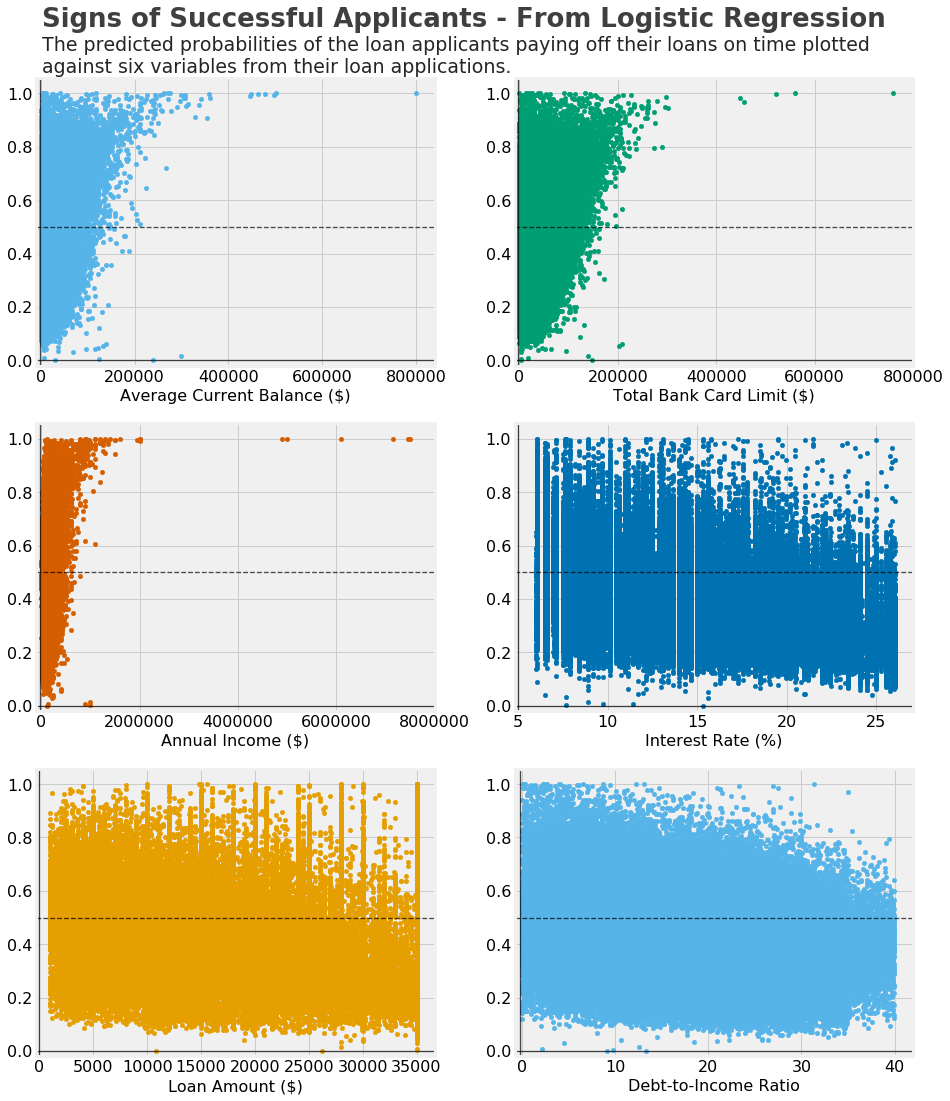

In [42]:
import matplotlib.pyplot as plt
import matplotlib.style as style
from matplotlib import cm
style.use('fivethirtyeight')
%matplotlib inline

# Colorblind-friendly colors
colors = [[230/255,159/255,0], [86/255,180/255,233/255], [0,158/255,115/255], 
          [213/255,94/255,0], [0,114/255,178/255]]

fig = plt.figure(figsize = (14, 18))
# List of axes
axes = []
[axes.append(fig.add_subplot(3,2,(i+1))) for i in range(6)]

#ax1 = fig.add_subplot(321)
#ax2 = fig.add_subplot(322)
#ax3 = fig.add_subplot(323)
#ax4 = fig.add_subplot(324)
#ax5 = fig.add_subplot(325)
#ax6 = fig.add_subplot(326)

axes[0].axhline(.5, 0, 1, linestyle = 'dashed', lw = 1.3, color = 'black', alpha = .7)
predicted_loans_lr.plot.scatter(x = 'avg_cur_bal', y = 'predicted_loan_status', ax = axes[0], 
                                color = colors[1], fontsize = 16)
axes[0].axvline(-2000, 0, 1, lw = 1.3, color = 'black', alpha = .7)

axes[1].axhline(.5, 0, 1, linestyle = 'dashed', lw = 1.3, color = 'black', alpha = .7)
predicted_loans_lr.plot.scatter(x = 'total_bc_limit', y = 'predicted_loan_status', ax = axes[1], 
                                color = colors[2], fontsize = 16)
axes[1].axvline(-2000, 0, 1, lw = 1.3, color = 'black', alpha = .7)

axes[2].axhline(.5, 0, 1, linestyle = 'dashed', lw = 1.3, color = 'black', alpha = .7)
predicted_loans_lr.plot.scatter(x = 'annual_inc', y = 'predicted_loan_status', ax = axes[2], 
                                color = colors[3], fontsize = 16)
axes[2].axvline(-20000, 0, 1, lw = 1.3, color = 'black', alpha = .7)

axes[3].axhline(.5, 0, 1, linestyle = 'dashed', lw = 1.3, color = 'black', alpha = .7)
predicted_loans_lr.plot.scatter(x = 'int_rate', y = 'predicted_loan_status', ax = axes[3], 
                                color = colors[4], fontsize = 16)
axes[3].axvline(5, 0, 1, lw = 1.3, color = 'black', alpha = .7)

axes[4].axhline(.5, 0, 1, linestyle = 'dashed', lw = 1.3, color = 'black', alpha = .7)
predicted_loans_lr.plot.scatter(x = 'loan_amnt', y = 'predicted_loan_status', ax = axes[4],
                                color = colors[0], fontsize = 16)
axes[4].axvline(0, 0, 1, lw = 1.3, color = 'black', alpha = .7)

axes[5].axhline(.5, 0, 1, linestyle = 'dashed', lw = 1.3, color = 'black', alpha = .7)
predicted_loans_lr.plot.scatter(x = 'dti', y = 'predicted_loan_status', ax = axes[5],
                                color = colors[1], fontsize = 16)
axes[5].axvline(-.2, 0, 1, lw = 1.3, color = 'black', alpha = .7)

[axis.axhline(0, 0, 1, lw = 1.3, color = 'black', alpha = .7) for axis in axes]

axes[0].set_xlabel('Average Current Balance ($)', fontsize = 16)
axes[1].set_xlabel('Total Bank Card Limit ($)', fontsize = 16)
axes[2].set_xlabel('Annual Income ($)', fontsize = 16)
axes[3].set_xlabel('Interest Rate (%)', fontsize = 16)
axes[4].set_xlabel('Loan Amount ($)', fontsize = 16)
axes[5].set_xlabel('Debt-to-Income Ratio', fontsize = 16)

[axis.set_ylabel('') for axis in axes]
axes[0].set_xticks([0, 200000, 400000, 600000, 800000])
axes[1].set_xticks([0, 200000, 400000, 600000, 800000])
axes[2].set_xticks([0, 2000000, 4000000, 6000000, 8000000])
axes[3].set_xticks([5, 10, 15, 20, 25])
axes[5].set_xticks([0, 10, 20, 30, 40])

axes[0].set_xlim(xmin = -10000)
axes[1].set_xlim(xmin = -10000)
axes[2].set_xlim(xmin = -100000)
axes[3].set_xlim(xmin = 4.8)
axes[4].set_xlim(xmin = -300)
axes[5].set_xlim(xmin = -.8)

[axis.set_ylim(ymin = -.02) for axis in axes]

axes[0].text(2000, 1.25, "Signs of Successful Applicants - From Logistic Regression", fontsize = 26, weight = 'bold', alpha = .75)
axes[0].text(2000, 1.08, "The predicted probabilities of the loan applicants paying off their loans on time plotted\nagainst six variables from their loan applications.", fontsize = 19, alpha = .85);

We see a slight positive correlation between the borrowers' average current balances (across all of their accounts), total bank card limits, and average income versus their predicted probabilities of paying off their loans on time. For these three variables, the predicted probability of paying off loans on time flattens at 1 for the outlier values. This result for annual incomes makes sense, as those who earn more money are more likely to pay off their loans on time. This may also explain the relationship between predicted probability and average current balance, and predicted probability and bank card limit.

The plots of the borrowers' predicted probabilities of paying off their loans versus their interest rate and loan amount are similar in that a negative correlation can be seen in the upper halves of the plots (probabilities above 0.5), but these trends are muddled by scattered points. This proposed trend would imply that borrowers who received high interest rates are less likely to pay off their loans on time. Likewise, this proposed trend would imply that borrowers who loan large amounts of money are less likely to pay off their loans on time. 

This similar trend is seen much more clearly in the figure showing the predicted probabiltiies against their debt-to-income (dti) ratios. This figure should reinforce the fact that investors should be aware of loan applicants with high debt-to-income ratios, as this reflects poorly on their ability to manage monthly payments and pay off debts.

From our evaluation of the numerical values in the dataset, the logistic regression model predicts that loan applicants who show financial stability and responsibility are most likely to pay off their loans. The financial stability and responsibility is shown in the borrowers' incomes, credit, money in their balances, and debt payments.

It is also worth looking at trends in the categorical variables. More specifically, we will look at the categorical variables "term" and "home_ownership" for loan applicants who were predicted to pay off their loans versus those who were predicted to charge off their loans.

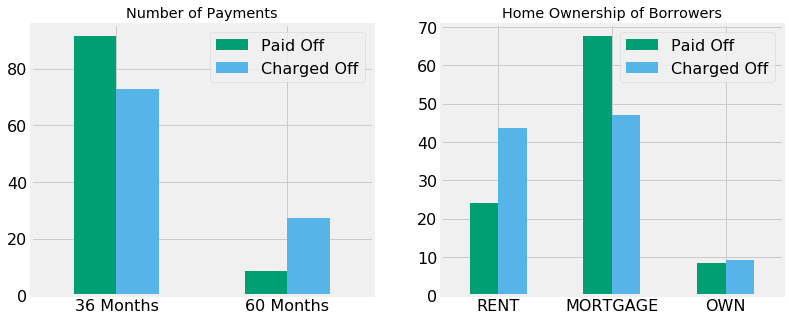

In [43]:
# Recover the DataFrame with categorical variable columns before they were converted to dummy columns
# Add predictions to this DataFrame
prepared_loans_lr = prepared_loans.copy()
prepared_loans_lr['predicted_loan_status_lr'] = predictions_lr

# Separate into loan applicants predicted to pay off their loans from those expected to fail
payoff_lr = prepared_loans_lr[prepared_loans_lr['predicted_loan_status_lr'] == 1]
chargeoff_lr = prepared_loans_lr[prepared_loans_lr['predicted_loan_status_lr']  == 0]

# term
term_payoff_lr = payoff_lr['term'].value_counts() / payoff_lr.shape[0] * 100
term_chargeoff_lr = chargeoff_lr['term'].value_counts() / chargeoff_lr.shape[0] * 100

term_lr = pd.concat((term_payoff_lr, term_chargeoff_lr), axis = 1)
term_lr.index = ['36 Months', '60 Months']

# home_ownership
home_payoff_lr = payoff_lr['home_ownership'].value_counts() / payoff_lr.shape[0] * 100
home_chargeoff_lr = chargeoff_lr['home_ownership'].value_counts() / chargeoff_lr.shape[0] * 100
home_payoff_lr = home_payoff_lr.reindex(['RENT', 'MORTGAGE', 'OWN', 'OTHER', 'NONE'])
home_chargeoff_lr = home_chargeoff_lr.reindex(['RENT', 'MORTGAGE', 'OWN', 'OTHER', 'NONE'])

home_lr = pd.concat((home_payoff_lr, home_chargeoff_lr), axis = 1)
home_lr = home_lr.drop(index = ['OTHER', 'NONE'])    # Frequencies too low
home_lr.columns = ['Pay Off', 'Charge Off']

fig = plt.figure(figsize = (12,5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

term_lr.plot.bar(color = colors[2::-1], ax = ax1, fontsize = 16,
                 title = 'Number of Payments', rot = 0)
home_lr.plot.bar(color = colors[2::-1], ax = ax2, fontsize = 16,
                 title = 'Home Ownership of Borrowers', rot = 0)
ax1.legend(['Paid Off', 'Charged Off'], fontsize = 16)
ax2.legend(['Paid Off', 'Charged Off'], fontsize = 16)

We see that among the loan applicants who plan to pay off their loans in 36 months, more of the borrowers are expected to pay off their loans than charge off their loans. The opposite can be said for the loan applicants who plan to pay off their loans in 60 months. Investors will therefore wish to fund loans that will be paid off in 36 months.

Among the loan applicants who are currently renting, more are expected to charge off their loans than pay them off. Among the loan applicants who are on a mortgage, more are expected to actually pay off their loans than charge them off. The numbers are roughly equal for loan applicants who are owning houses with no mortgages.

## Random Forest
Let us see if a more complex algorithm, the random forest, can provide different insight into predicting the borrowers' abilities to pay off their loans on time. Noting the class imbalance in our dataset, we will start by applying the same penalty for the misclassification of the minority class from our logistic regression model. For the sake of demonstration, when we apply the random forest algorithm, we will specify the seed in advance, although this wouldn't be done in practice. 

In [44]:
from sklearn.ensemble import RandomForestClassifier

penalty = {
    0: 8,
    1: 1
}

# Instantiate the random forest model that penalizes the misclassification of the minority class
rf = RandomForestClassifier(random_state = 42, class_weight = penalty)

# Train the random forest model across 10 folds, predict loan status
predictions_proba_rf = cross_val_predict(rf, features, target, cv = 10, method = 'predict_proba')[:,1]

predictions_rf = np.round(predictions_proba_rf)

# Output the false and true positive rates
tpr_and_fpr(predictions_rf, target)

False positive rate:  0.8769563411944957
True positive rate:  0.8963627769464909


Unfortunately, even with the same penalty that worked for the logistic regression model, the more complex random forest classifier has nearly equal false and true positive rates. The model is still weighing too heavily on the 1 class and is still mostly predicting 1s. 

We can address this problem by tweaking hyperparameters of our random forest, such as the maximum depth of the trees or the penalty for misclassifications. We will begin by performing a cross-validated grid search across our parameter grid. We will be judging the parameters by the area under the receiving operator characteristic (AUROC, although it is widely called AUC), which evaluates the model's predictability in comparison to uniform randomness, and is related to maximizing the true positive rate and minimizing the false positive rate.

In [69]:
from sklearn.model_selection import GridSearchCV

# Define parameter grid for the grid search
parameters = {
    'class_weight': [{0: p, 1: 1} for p in np.arange(8, 12.5, .5)],
    'max_depth': [10, 15],
    'min_samples_leaf': [100, 200, 400]
}

# Instantiate the random forest classifier model without the parameter grid
rf = RandomForestClassifier(random_state = 42, bootstrap = True, max_features = 'auto', n_estimators = 50)

# Define the grid. Score against AUROC. Run on all CPUs.
rf_grid = GridSearchCV(rf, param_grid = parameters, scoring = 'roc_auc', cv = 5, refit = True, n_jobs = -1)

# Fit the models in the grid
rf_grid.fit(features, target)

# Output the parameters for the best-performing model
print('Best parameters from GridSearchCV: ')
print(rf_grid.best_params_)

# Obtain the best estimator object
rf = rf_grid.best_estimator_

# Train the random forest model across 10 folds, predict loan status
predictions_proba_rf = cross_val_predict(rf, features, target, cv = 10, method = 'predict_proba')[:,1]

predictions_rf = np.round(predictions_proba_rf)

# Output the false and true positive rates
tpr_and_fpr(predictions_rf, target) 

Best parameters from GridSearchCV: 
{'class_weight': {0: 10.5, 1: 1}, 'max_depth': 10, 'min_samples_leaf': 400}
False positive rate:  0.08714578232169194
True positive rate:  0.21383174418709675


We see that based on the ROC-AUC error metric, the best parameters are a penalty of 10.5 on the minority class, 10 layers for the decision trees in the random forest, and a minimum of 400 samples per leaf in the decision trees. Let us continue to tune the parameters. Let us say we are happy with the penalty, but wish to tweak the depth and minimum samples per leaf. The reasoning behind this is that we may be satisfied with increasing the false positive rate a tiny bit if that results in a noticeable increase in the true positive rate, something that isn't accounted for in the optimization of the ROC-AUC score.

In [75]:
# Write list of min_samples_leaf values
samples_in_leaf = [100, 200, 300, 400]

for leaf_number in samples_in_leaf:
    # Instantiate the random forest model that penalizes the misclassification of the minority class
    rf = RandomForestClassifier(random_state = 42, class_weight = {0: 10.5, 1: 1}, bootstrap = True,
                                max_features = 'auto', max_depth = 10, min_samples_leaf = leaf_number,
                                n_estimators = 50)

    # Train the random forest model across 10 folds, predict loan status
    predictions_proba_rf = cross_val_predict(rf, features, target, 
                                             cv = 10, method = 'predict_proba', n_jobs = -1)[:,1]

    predictions_rf = np.round(predictions_proba_rf)

    # Output the false and true positive rates
    tpr_and_fpr(predictions_rf, target)

False positive rate:  0.09704025086988273
True positive rate:  0.23515350038687458
False positive rate:  0.09328865787476552
True positive rate:  0.2262869977028382
False positive rate:  0.08912181221988344
True positive rate:  0.21801059163206873
False positive rate:  0.08714578232169194
True positive rate:  0.21383174418709675


What we see is that both the false and true positive rates decrease with an increasing minimum number of samples per leaf. We are okay with a false positive rate of 9.7%, as that is still below 10%. Having a minimum of 100 samples per leaf also provides us with a true positive rate of 23.5%, which is higher than 21.4% from the grid search, and higher than the 19.7% from logistic regression.

Let us tweak the max_depth parameter.

In [77]:
# Write list of min_samples_leaf values
depths = [5, 8, 10, 15]

model_probabilities = []

for depth in depths:
    # Instantiate the random forest model that penalizes the misclassification of the minority class
    rf = RandomForestClassifier(random_state = 42, class_weight = {0: 10.5, 1: 1}, bootstrap = True,
                                max_features = 'auto', max_depth = depth, min_samples_leaf = 100,
                                n_estimators = 50)

    # Train the random forest model across 10 folds, predict loan status
    predictions_proba_rf = cross_val_predict(rf, features, target, 
                                             cv = 10, method = 'predict_proba', n_jobs = -1)[:,1]
    model_probabilities.append(predictions_proba_rf)

    predictions_rf = np.round(predictions_proba_rf)

    # Output the false and true positive rates
    tpr_and_fpr(predictions_rf, target)

False positive rate:  0.03317725560949067
True positive rate:  0.1193801577003092
False positive rate:  0.0749459455589444
True positive rate:  0.19655034336999358
False positive rate:  0.09704025086988273
True positive rate:  0.23515350038687458
False positive rate:  0.12769735240631758
True positive rate:  0.29185395710961043


We will stick to a maximum depth of 10 and 100 minimum samples per leaf for our random forest model, which enacts a penalty of 10.5 on the misclassification on the minority class. With this model, we end up with a false positive rate below 10% and a true positive rate of 23.5%. With a false positive rate close to what we calculated from our logistic regression model, we now have a higher true positive rate. An investor will likely wish to follow this random forest model over our logistic regerssion model, as they will earn more money by taking on more lucrative funding opportunities.

Let us test our random forest model for overfitting.

In [78]:
# Calculate the false and true positive rates on training and test datasets
# The dataset will be split into a training set (75%) and test set (25%)
# Use parameters determined from grid search and hyperparameter tweaking
rf = RandomForestClassifier(random_state = 42, class_weight = {0: 10.5, 1: 1}, bootstrap = True,
                            max_features = 'auto', max_depth = 10, min_samples_leaf = 100,
                            n_estimators = 50, n_jobs = -1)

train_and_test(rf, features, target)

FPR and TRP for Training: 
False positive rate:  0.05331395571193636
True positive rate:  0.2575091795581773
FPR and TPR for Test
False positive rate:  0.07284956962891181
True positive rate:  0.2527545386599802


We notice that the values for the false and true positive rates between the training and test datasets are close to each other, meaning our random forest algorithm is not overfitting training data. We also notice that the training and test false positive rates are lower than those from logistic regression (roughly ~10%), and the training and test true positive rates are higher than those from logistic regression (~19%), indicating that our random forest model is displaying a better predictive performance.

Like we have done with the results from our logistic regression model, let us look at the correlations between the predicted probabilities of the borrowers successfully paying off their loans on time against variables on their loan applications.

In [79]:
# Create a DataFrame with the features and a column with the predicted probabilities
predicted_loans_rf = features
predicted_loans_rf['predicted_loan_status'] = model_probabilities[2]

# Generate a correlation matrix from this DataFrame. Get correlations to predicted_loan_status
rf_corr_mat = predicted_loans_rf.corr()
predicted_loan_rf_corr = np.abs(rf_corr_mat['predicted_loan_status'])
predicted_loan_rf_corr[predicted_loan_rf_corr > .1].sort_values(ascending = False)

predicted_loan_status               1.000000
int_rate                            0.717484
term_ 36 months                     0.543039
term_ 60 months                     0.543039
total_bc_limit                      0.309118
avg_cur_bal                         0.306044
tot_cur_bal                         0.284818
bc_util                             0.267028
dti                                 0.248054
verification_status_Not Verified    0.219916
revol_util                          0.218260
annual_inc                          0.216142
mo_sin_rcnt_rev_tl_op               0.204940
acc_open_past_24mths                0.203572
mo_sin_rcnt_tl                      0.197188
mort_acc                            0.194617
home_ownership_MORTGAGE             0.173364
home_ownership_RENT                 0.164775
mo_sin_old_rev_tl_op                0.156221
inq_last_6mths                      0.153362
verification_status_Verified        0.144671
num_actv_rev_tl                     0.138861
mths_since

We will be plotting a few of these numerical variables against the predicted probabilities. What we notice is that there is a stronger correlation between the interest rate and predicted probability than from logistic regression. The opposite can be said for loan amount.

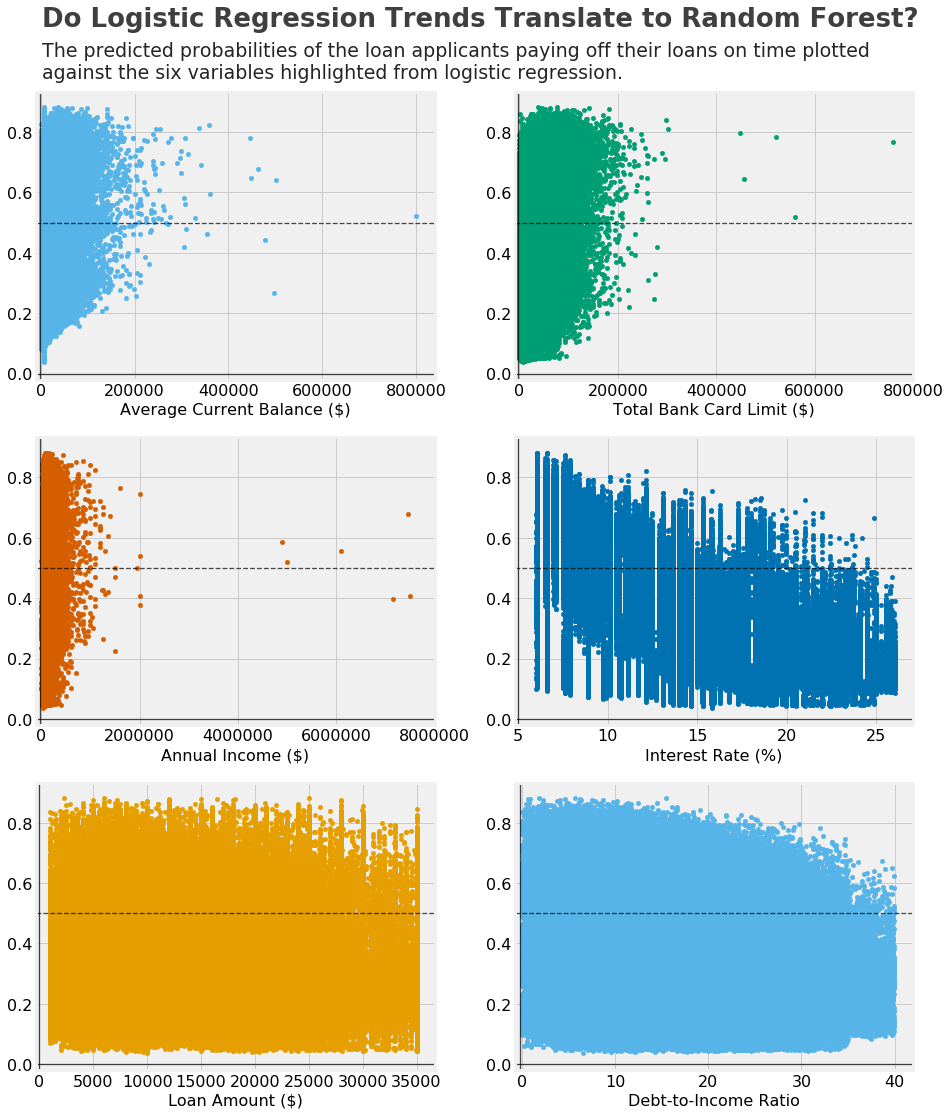

In [80]:
fig = plt.figure(figsize = (14, 18))
# List of axes
axes = []
[axes.append(fig.add_subplot(3,2,(i+1))) for i in range(6)]

axes[0].axhline(.5, 0, 1, linestyle = 'dashed', lw = 1.3, color = 'black', alpha = .7)
predicted_loans_rf.plot.scatter(x = 'avg_cur_bal', y = 'predicted_loan_status', ax = axes[0], 
                                color = colors[1], fontsize = 16)
axes[0].axvline(-2000, 0, 1, lw = 1.3, color = 'black', alpha = .7)

axes[1].axhline(.5, 0, 1, linestyle = 'dashed', lw = 1.3, color = 'black', alpha = .7)
predicted_loans_rf.plot.scatter(x = 'total_bc_limit', y = 'predicted_loan_status', ax = axes[1], 
                                color = colors[2], fontsize = 16)
axes[1].axvline(-2000, 0, 1, lw = 1.3, color = 'black', alpha = .7)

axes[2].axhline(.5, 0, 1, linestyle = 'dashed', lw = 1.3, color = 'black', alpha = .7)
predicted_loans_rf.plot.scatter(x = 'annual_inc', y = 'predicted_loan_status', ax = axes[2], 
                                color = colors[3], fontsize = 16)
axes[2].axvline(-20000, 0, 1, lw = 1.3, color = 'black', alpha = .7)

axes[3].axhline(.5, 0, 1, linestyle = 'dashed', lw = 1.3, color = 'black', alpha = .7)
predicted_loans_rf.plot.scatter(x = 'int_rate', y = 'predicted_loan_status', ax = axes[3], 
                                color = colors[4], fontsize = 16)
axes[3].axvline(5, 0, 1, lw = 1.3, color = 'black', alpha = .7)

axes[4].axhline(.5, 0, 1, linestyle = 'dashed', lw = 1.3, color = 'black', alpha = .7)
predicted_loans_rf.plot.scatter(x = 'loan_amnt', y = 'predicted_loan_status', ax = axes[4],
                                color = colors[0], fontsize = 16)
axes[4].axvline(0, 0, 1, lw = 1.3, color = 'black', alpha = .7)

axes[5].axhline(.5, 0, 1, linestyle = 'dashed', lw = 1.3, color = 'black', alpha = .7)
predicted_loans_rf.plot.scatter(x = 'dti', y = 'predicted_loan_status', ax = axes[5],
                                color = colors[1], fontsize = 16)
axes[5].axvline(-.2, 0, 1, lw = 1.3, color = 'black', alpha = .7)

[axis.axhline(0, 0, 1, lw = 1.3, color = 'black', alpha = .7) for axis in axes]

axes[0].set_xlabel('Average Current Balance ($)', fontsize = 16)
axes[1].set_xlabel('Total Bank Card Limit ($)', fontsize = 16)
axes[2].set_xlabel('Annual Income ($)', fontsize = 16)
axes[3].set_xlabel('Interest Rate (%)', fontsize = 16)
axes[4].set_xlabel('Loan Amount ($)', fontsize = 16)
axes[5].set_xlabel('Debt-to-Income Ratio', fontsize = 16)

[axis.set_ylabel('') for axis in axes]
axes[0].set_xticks([0, 200000, 400000, 600000, 800000])
axes[1].set_xticks([0, 200000, 400000, 600000, 800000])
axes[2].set_xticks([0, 2000000, 4000000, 6000000, 8000000])
axes[3].set_xticks([5, 10, 15, 20, 25])
axes[5].set_xticks([0, 10, 20, 30, 40])

axes[0].set_xlim(xmin = -10000)
axes[1].set_xlim(xmin = -10000)
axes[2].set_xlim(xmin = -100000)
axes[3].set_xlim(xmin = 4.8)
axes[4].set_xlim(xmin = -300)
axes[5].set_xlim(xmin = -.8)

[axis.set_ylim(ymin = -.02) for axis in axes]

axes[0].text(2000, 1.15, "Do Logistic Regression Trends Translate to Random Forest?", fontsize = 26, weight = 'bold', alpha = .75)
axes[0].text(2000, .98, "The predicted probabilities of the loan applicants paying off their loans on time plotted\nagainst the six variables highlighted from logistic regression.", fontsize = 19, alpha = .85);

What is interesting is that our random forest model never gave a predicted probability of 1 to any of the loan applications. 

We see a more distinct decrease in the predicted probabilities of paying off loans versus the interest rate, signifying the weight on the interest rate in the random forest model. This is logical, as the interest rate is a grade given to a loan application, such that this should be one of the first values an investor should look at before funding a loan. 

Similar to what was observed from the logistic regression mode, there is a negative trend between the predicted probabilities and the debt-to-income ratio.

It is hard to tell if the random forest model rewards applicants with higher annual incomes, higher bank card limits, or larger loan amounts.

It _can_ be argued that distributions of predicted probabilities for specific bins of average current balance values are skewed towards 1 if the average current balance is high.

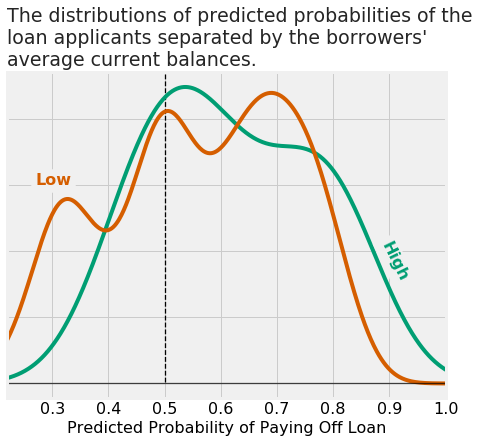

In [81]:
fig = plt.figure(figsize = (7, 6))
ax = fig.add_subplot(111)

# Get slice of dataset in a bin for average current balance values from $300,000 to $400,000.
high_current_balance = predicted_loans_rf[(predicted_loans_rf['avg_cur_bal'] >= 300000) &
                                       (predicted_loans_rf['avg_cur_bal'] < 400000)]

# Get slice of dataset in a bin for average current balance values from $100,000 to $200,000.
low_current_balance = predicted_loans_rf[(predicted_loans_rf['avg_cur_bal'] >= 100000) &
                                       (predicted_loans_rf['avg_cur_bal'] < 200000)]

ax.axvline(.5, .05, 1, color = 'black', lw = 1.3, ls = 'dashed')

# For each slice, plot estimated distribution function from histogram of predicted probabilities 
high_current_balance['predicted_loan_status'].plot(kind = 'kde', c = colors[2], fontsize = 16)
low_current_balance['predicted_loan_status'].plot(kind = 'kde', c = colors[3], fontsize = 16)

ax.text(.88, 1, 'High', fontsize = 16, weight = 'bold', color = colors[2], 
        backgroundcolor = '#f0f0f0', rotation = -64)
ax.text(.27, 1.5, 'Low', fontsize = 16, weight = 'bold', color = colors[3], 
        backgroundcolor = '#f0f0f0')

ax.axhline(0, color = 'black', linewidth = 1.3, alpha = .7)
ax.set_xlim([.22, 1])
ax.set_xlabel('Predicted Probability of Paying Off Loan', fontsize = 16)
ax.set_ylabel('')
ax.tick_params(labelleft = False)

ax.text(.22, 2.4, "The distributions of predicted probabilities of the\nloan applicants separated by the borrowers'\naverage current balances.", fontsize = 19, alpha = .85);

Looking at other numerical variables, we see a slight negative trend between the predicted probabilities and the number of active revolving trades. We did not show this plot for our results from logistic regression due to a lack of trends between the two variables.

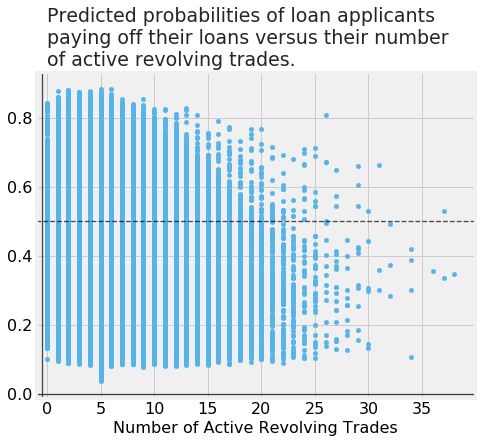

In [82]:
fig = plt.figure(figsize = (7, 6))
ax = fig.add_subplot(111)

predicted_loans_rf.plot.scatter(x = 'num_actv_rev_tl', y = 'predicted_loan_status', 
                                color = colors[1], fontsize = 16, ax = ax)

ax.axvline(-.5, lw = 1.3, alpha = .7, color = 'black')
ax.axhline(0, lw = 1.3, alpha = .7, color = 'black')
ax.axhline(0.5, lw = 1.3, alpha = .7, ls = 'dashed', color = 'black')

ax.set_xlabel('Number of Active Revolving Trades', fontsize = 16)
ax.set_ylabel('')
ax.set_xlim(xmin = -1)
ax.text(0, .95, "Predicted probabilities of loan applicants\npaying off their loans versus their number\nof active revolving trades.", fontsize = 19, alpha = .85);

Having too many active revolving trades may be a sign that a loan applicant has high unpaid revolving balances. This indicates that these applicants are having trouble managing their credit.

Let us revisit the categorical variables term and home_ownership, and see how these categories vary for loan applicants who are predicted to pay off their loans versus those who are predicted to fail. 

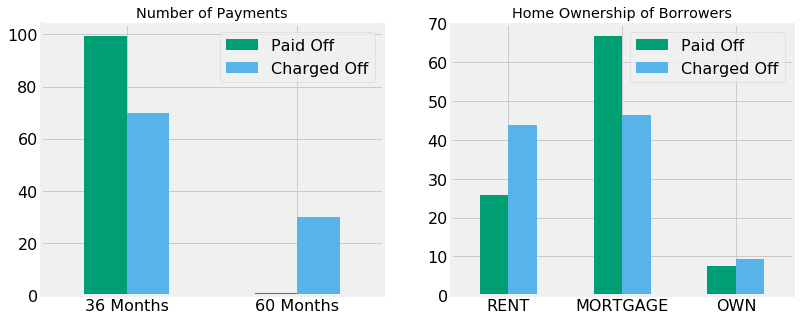

In [85]:
# Recover the DataFrame with categorical variable columns before they were converted to dummy columns
# Add predictions to this DataFrame
prepared_loans_rf = prepared_loans.copy()
prepared_loans_rf['predicted_loan_status_rf'] = np.round(model_probabilities[2])

# Separate into loan applicants predicted to pay off their loans from those expected to fail
payoff_rf = prepared_loans_rf[prepared_loans_rf['predicted_loan_status_rf'] == 1]
chargeoff_rf = prepared_loans_rf[prepared_loans_rf['predicted_loan_status_rf']  == 0]

# term
term_payoff_rf = payoff_rf['term'].value_counts() / payoff_rf.shape[0] * 100
term_chargeoff_rf = chargeoff_rf['term'].value_counts() / chargeoff_rf.shape[0] * 100

term_rf = pd.concat((term_payoff_rf, term_chargeoff_rf), axis = 1)
term_rf.index = ['36 Months', '60 Months']

# home_ownership
home_payoff_rf = payoff_rf['home_ownership'].value_counts() / payoff_rf.shape[0] * 100
home_chargeoff_rf = chargeoff_rf['home_ownership'].value_counts() / chargeoff_rf.shape[0] * 100
home_payoff_rf = home_payoff_rf.reindex(['RENT', 'MORTGAGE', 'OWN', 'OTHER', 'NONE'])
home_chargeoff_rf = home_chargeoff_rf.reindex(['RENT', 'MORTGAGE', 'OWN', 'OTHER', 'NONE'])

home_rf = pd.concat((home_payoff_rf, home_chargeoff_rf), axis = 1)
home_rf = home_rf.drop(index = ['OTHER', 'NONE'])    # Frequencies too low
home_rf.columns = ['Pay Off', 'Charge Off']

fig = plt.figure(figsize = (12,5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

term_rf.plot.bar(color = colors[2::-1], ax = ax1, fontsize = 16,
                 title = 'Number of Payments', rot = 0)
home_rf.plot.bar(color = colors[2::-1], ax = ax2, fontsize = 16,
                 title = 'Home Ownership of Borrowers', rot = 0)
ax1.legend(['Paid Off', 'Charged Off'], fontsize = 16)
ax2.legend(['Paid Off', 'Charged Off'], fontsize = 16)

We observe similar trends as we have observed from the logistic regression model. However, what is notable is that almost none of the loan applicants who plan to pay off their loans in 60 months are predicted to pay off their loans. Investors will want to fund only loans that are expected to be paid off in 36 months.

### Comparisons with Logistic Regression
We noticed there were a few variables that had unclear trends with the predicted probabilities:
- Interest rate from logistic regression
- Annual income from random forest

For each of these variables, let us plot the probability distributions estimated from histograms for loan applicants who are predicted to pay off their loans versus those who are predicted to charge off their loans.

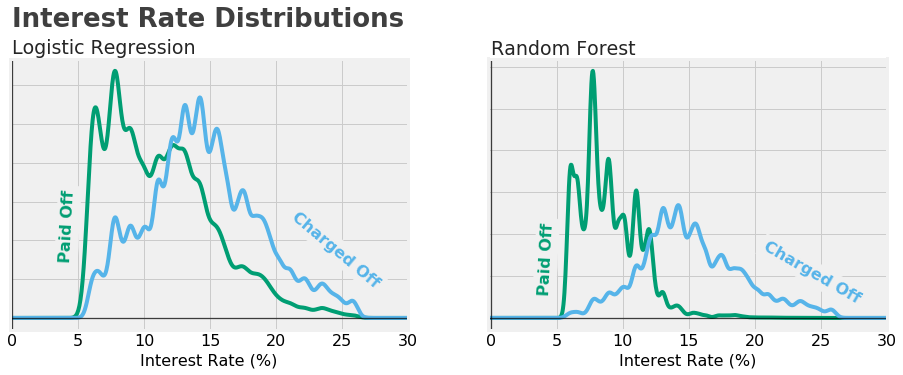

In [86]:
fig = plt.figure(figsize = (14, 5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

payoff_lr['int_rate'].plot(kind = 'kde', c = colors[2], ax = ax1, fontsize = 16)
chargeoff_lr['int_rate'].plot(kind = 'kde', c = colors[1], ax = ax1, fontsize = 16)
ax1.set_xlim([-.2, 30])
ax1.axhline(0, color = 'black', lw = 1.3, alpha = .7)
ax1.axvline(0, color = 'black', lw = 1.3, alpha = .7)
ax1.set_xlabel('Interest Rate (%)', fontsize = 16)
ax1.set_ylabel('')
ax1.text(3.5, .06, 'Paid Off', fontsize = 16, weight = 'bold', color = colors[2], 
        backgroundcolor = '#f0f0f0', rotation = 87)
ax1.text(21, .05, 'Charged Off', fontsize = 16, weight = 'bold', color = colors[1], 
        backgroundcolor = '#f0f0f0', rotation = -40)
ax1.text(0, .15, 'Interest Rate Distributions', fontsize = 26, weight = 'bold', alpha = .75)
ax1.text(0, .136, 'Logistic Regression',fontsize = 19, alpha = .85)
ax1.tick_params(labelleft = False)

payoff_rf['int_rate'].plot(kind = 'kde', c = colors[2], ax = ax2, fontsize = 16)
chargeoff_rf['int_rate'].plot(kind = 'kde', c = colors[1], ax = ax2, fontsize = 16)
ax2.set_xlim([-.2, 30])
ax2.axhline(0, color = 'black', lw = 1.3, alpha = .7)
ax2.axvline(0, color = 'black', lw = 1.3, alpha = .7)
ax2.set_xlabel('Interest Rate (%)', fontsize = 16)
ax2.set_ylabel('')
ax2.text(3.5, .1, 'Paid Off', fontsize = 16, weight = 'bold', color = colors[2], 
        backgroundcolor = '#f0f0f0', rotation = 87)
ax2.text(20.5, .08, 'Charged Off', fontsize = 16, weight = 'bold', color = colors[1], 
        backgroundcolor = '#f0f0f0', rotation = -30)
ax2.text(0, .315, 'Random Forest', fontsize = 19, alpha = .85)
ax2.tick_params(labelleft = False)

For either model, we see that loan applicants with higher interest rates are less likely to pay off their loans on time. The difference is that the overlap between the distributions for the loan applicants who are predicted to pay off their loans and for those who are predicted to charge off their loans is smaller for the random forest model than for the logistic regression model. We can see that the interest rate has a greater weight in the prediction of the success of loan applications in the random forest model than in the logistic regression model. If the investor follows the random forest model, they will be avoid funding loan applications with interest rates above roughly 13%.

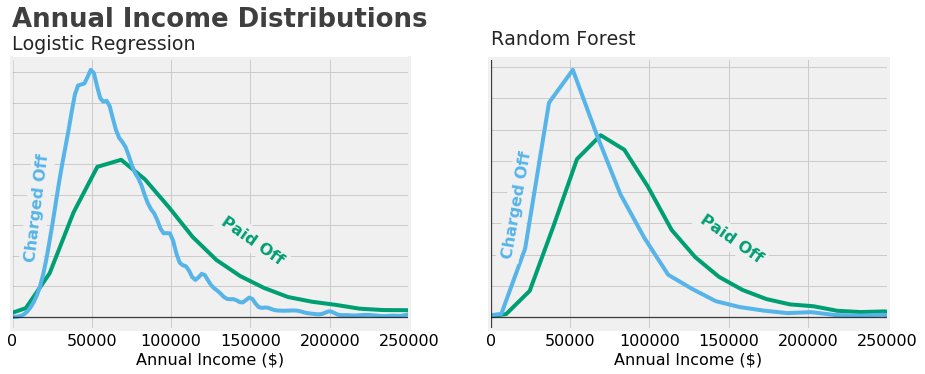

In [87]:
fig = plt.figure(figsize = (14, 5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

payoff_lr['annual_inc'].plot(kind = 'kde', c = colors[2], ax = ax1, fontsize = 16)
chargeoff_lr['annual_inc'].plot(kind = 'kde', c = colors[1], ax = ax1, fontsize = 16)
ax1.set_xlim([-1000, 250000])
ax1.axhline(0, color = 'black', lw = 1.3, alpha = .7)
ax1.axvline(0, color = 'black', lw = 1.3, alpha = .7)
ax1.set_xlabel('Annual Income ($)', fontsize = 16)
ax1.set_ylabel('')
ax1.text(130000, .000006, 'Paid Off', fontsize = 16, weight = 'bold', color = colors[2], 
        backgroundcolor = '#f0f0f0', rotation = -35)
ax1.text(7000, .000010, 'Charged Off', fontsize = 16, weight = 'bold', color = colors[1], 
        backgroundcolor = '#f0f0f0', rotation = 83)
ax1.text(0, .000019, 'Annual Income Distributions', fontsize = 26, weight = 'bold', alpha = .75)
ax1.text(0, .0000175, 'Logistic Regression',fontsize = 19, alpha = .85)
ax1.tick_params(labelleft = False)

payoff_rf['annual_inc'].plot(kind = 'kde', c = colors[2], ax = ax2, fontsize = 16)
chargeoff_rf['annual_inc'].plot(kind = 'kde', c = colors[1], ax = ax2, fontsize = 16)
ax2.set_xlim([-1000, 250000])
ax2.axhline(0, color = 'black', lw = 1.3, alpha = .7)
ax2.axvline(0, color = 'black', lw = 1.3, alpha = .7)
ax2.set_xlabel('Annual Income ($)', fontsize = 16)
ax2.set_ylabel('')
ax2.text(130000, .000006, 'Paid Off', fontsize = 16, weight = 'bold', color = colors[2], 
        backgroundcolor = '#f0f0f0', rotation = -35)
ax2.text(6000, .000010, 'Charged Off', fontsize = 16, weight = 'bold', color = colors[1], 
        backgroundcolor = '#f0f0f0', rotation = 80)
ax2.text(0, .0000175, 'Random Forest', fontsize = 19, alpha = .85)
ax2.tick_params(labelleft = False)

We see that the distributions of the annual income of loan applicants who succeed in paying off their loans and those who don't are similar between the two models. It is noted, however, that the tail of the "Paid Off" annual income distribution from logistic regression is greater than that from random forest. This greater tail may explain the positive trend observed between the predicted probabilities of paying off loans and the annual income in the logistic regression model.

We have considered doing a similar analysis for the variable "Total Bank Card Limit", but we would have noticed the same observations that we have noticed from the annual income variable.

Based on our error metrics, we would likely recommend the random forest model to conservative investors. They will likely fund borrowers who have low interest rates, low debt-to-income ratios, good credit, a small number of active revolving trades, and plan to pay off their loans in 36 months.

## LightGBM
We were satisfied with employing the random forest algorithm on our dataset from the Lending Club. There is still a possibility that we can get more accurate predictions from decision trees. We can do so with gradient boosting implemented in LightGBM, where decision trees grow leaf-wise instead of level-wise. 

We will be using and evaluating a LightGBM model by splitting the dataset into training and test datasets to test for bias and variance. We will be training our LightGBM model by maximizing the area under the receiving operator characteristic (AUROC, although it is widely called AUC), which evaluates the model's predictability in comparison to uniform randomness. We will select the best parameters, including the penalty, through a cross-validated grid search.

In [92]:
import lightgbm as lgb

if __name__ == '__main__':
    # Split into train and test datasets. 70% in training, 30% in test
    X_train, X_test, y_train, y_test = train_test_split(features, target, test_size = .3, random_state = 42)

    parameters = {
        'scale_pos_weight': 1 / np.arange(11, 14),
        'learning_rate': [0.02,0.05],
        'num_leaves': [100, 250],
        'min_data_in_leaf': [800, 1200],
        'n_estimators': [500, 1000]
    }

    gbm = lgb.LGBMClassifier(objective = 'binary', verbose = 0, max_depth = 8)

    gbm_grid = GridSearchCV(gbm, param_grid = parameters, scoring = 'roc_auc', cv = 3, refit = True, n_jobs = 1)

    gbm_grid.fit(X_train, y_train)

    print('Best parameters from GridSearchCV: ')
    print(gbm_grid.best_params_)

    gbm = gbm_grid.best_estimator_


    gbm.fit(X_train, y_train,
            eval_set=[(X_test, y_test)],
            eval_metric='auc',
            early_stopping_rounds=5)

    y_pred = gbm.predict(X_test, num_iteration=gbm.best_iteration_)
    y_pred_train = gbm.predict(X_train, num_iteration=gbm.best_iteration_)

    print('Training:')
    tpr_and_fpr(y_pred_train, y_train)
    print('Test:')
    tpr_and_fpr(y_pred, y_test)

    print('Cross-validation prediction:')
    predictions_proba_gbm = cross_val_predict(gbm, features, target, cv = 5, method = 'predict_proba')[:,1]

    predictions_gbm = np.round(predictions_proba_gbm)

    tpr_and_fpr(predictions_gbm, target)

Best parameters from GridSearchCV: 
{'learning_rate': 0.02, 'min_data_in_leaf': 1200, 'n_estimators': 1000, 'num_leaves': 100, 'scale_pos_weight': 0.09090909090909091}
[1]	valid_0's auc: 0.711541
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's auc: 0.713276
[3]	valid_0's auc: 0.715062
[4]	valid_0's auc: 0.715538
[5]	valid_0's auc: 0.716182
[6]	valid_0's auc: 0.716714
[7]	valid_0's auc: 0.717703
[8]	valid_0's auc: 0.717914
[9]	valid_0's auc: 0.718478
[10]	valid_0's auc: 0.71854
[11]	valid_0's auc: 0.71892
[12]	valid_0's auc: 0.719312
[13]	valid_0's auc: 0.719469
[14]	valid_0's auc: 0.719635
[15]	valid_0's auc: 0.719746
[16]	valid_0's auc: 0.720024
[17]	valid_0's auc: 0.720231
[18]	valid_0's auc: 0.720331
[19]	valid_0's auc: 0.720423
[20]	valid_0's auc: 0.720518
[21]	valid_0's auc: 0.720633
[22]	valid_0's auc: 0.720734
[23]	valid_0's auc: 0.720856
[24]	valid_0's auc: 0.720939
[25]	valid_0's auc: 0.720971
[26]	valid_0's auc: 0.720981
[27]	valid_0's auc: 0.720962

[275]	valid_0's auc: 0.731348
[276]	valid_0's auc: 0.731369
[277]	valid_0's auc: 0.731393
[278]	valid_0's auc: 0.731402
[279]	valid_0's auc: 0.731443
[280]	valid_0's auc: 0.731464
[281]	valid_0's auc: 0.731492
[282]	valid_0's auc: 0.731504
[283]	valid_0's auc: 0.73153
[284]	valid_0's auc: 0.731549
[285]	valid_0's auc: 0.731586
[286]	valid_0's auc: 0.731606
[287]	valid_0's auc: 0.731622
[288]	valid_0's auc: 0.731665
[289]	valid_0's auc: 0.731699
[290]	valid_0's auc: 0.73172
[291]	valid_0's auc: 0.73175
[292]	valid_0's auc: 0.731777
[293]	valid_0's auc: 0.731807
[294]	valid_0's auc: 0.731812
[295]	valid_0's auc: 0.731823
[296]	valid_0's auc: 0.731846
[297]	valid_0's auc: 0.731869
[298]	valid_0's auc: 0.731889
[299]	valid_0's auc: 0.731929
[300]	valid_0's auc: 0.731942
[301]	valid_0's auc: 0.731958
[302]	valid_0's auc: 0.731984
[303]	valid_0's auc: 0.732006
[304]	valid_0's auc: 0.732037
[305]	valid_0's auc: 0.732059
[306]	valid_0's auc: 0.732075
[307]	valid_0's auc: 0.732093
[308]	valid_0

[553]	valid_0's auc: 0.735664
[554]	valid_0's auc: 0.735672
[555]	valid_0's auc: 0.735673
[556]	valid_0's auc: 0.735683
[557]	valid_0's auc: 0.73569
[558]	valid_0's auc: 0.735709
[559]	valid_0's auc: 0.735715
[560]	valid_0's auc: 0.735724
[561]	valid_0's auc: 0.735724
[562]	valid_0's auc: 0.73573
[563]	valid_0's auc: 0.73574
[564]	valid_0's auc: 0.735739
[565]	valid_0's auc: 0.735746
[566]	valid_0's auc: 0.735748
[567]	valid_0's auc: 0.735763
[568]	valid_0's auc: 0.735777
[569]	valid_0's auc: 0.735774
[570]	valid_0's auc: 0.735782
[571]	valid_0's auc: 0.735791
[572]	valid_0's auc: 0.735795
[573]	valid_0's auc: 0.735801
[574]	valid_0's auc: 0.735801
[575]	valid_0's auc: 0.735794
[576]	valid_0's auc: 0.735807
[577]	valid_0's auc: 0.735807
[578]	valid_0's auc: 0.735815
[579]	valid_0's auc: 0.735818
[580]	valid_0's auc: 0.73583
[581]	valid_0's auc: 0.73584
[582]	valid_0's auc: 0.735841
[583]	valid_0's auc: 0.735849
[584]	valid_0's auc: 0.735857
[585]	valid_0's auc: 0.735865
[586]	valid_0's

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Training:
False positive rate:  0.0566401048814962
True positive rate:  0.3504448065768597
Test:
False positive rate:  0.09362511893434824
True positive rate:  0.34340604161645377
Cross-validation prediction:
False positive rate:  0.09616678837865315
True positive rate:  0.2849955893288855


We note that the training and test false positive rates are similar to those from our random forest model (roughly 5% and 7% for training and test, respectively). Meanwhile, the training and test true positive rates are significantly higher than those from our random forest model (~25%).

From our cross-validation prediction, we have a false positive rate of 9.6%, which is comparable to our values from the logistic regression and random forest models. In the meantime, we also have a true positive rate of 28.5%, which is a significant improvement from what we calculated from the logistic regression and random forest models. This means an investor following this model will be earning more money by avoiding bad loans and funding more successful loans.

Let us examine the relationships between our features and our predictions, as we have done with the previous two models.

In [93]:
# Create a DataFrame with the features and a column with the predicted probabilities
predicted_loans_gbm = features
predicted_loans_gbm['predicted_loan_status'] = predictions_proba_gbm

# Generate a correlation matrix from this DataFrame. Get correlations to predicted_loan_status
gbm_corr_mat = predicted_loans_gbm.corr()
predicted_loan_gbm_corr = np.abs(gbm_corr_mat['predicted_loan_status'])
predicted_loan_gbm_corr[predicted_loan_gbm_corr > .1].sort_values(ascending = False)

predicted_loan_status               1.000000
int_rate                            0.717565
term_ 36 months                     0.463495
term_ 60 months                     0.463495
total_bc_limit                      0.282646
avg_cur_bal                         0.278621
dti                                 0.264815
tot_cur_bal                         0.256013
bc_util                             0.255272
acc_open_past_24mths                0.239575
revol_util                          0.219074
mo_sin_rcnt_rev_tl_op               0.213616
verification_status_Not Verified    0.210253
annual_inc                          0.209664
mo_sin_rcnt_tl                      0.207840
mort_acc                            0.199832
mo_sin_old_rev_tl_op                0.174222
home_ownership_MORTGAGE             0.174143
num_actv_rev_tl                     0.172373
inq_last_6mths                      0.172028
home_ownership_RENT                 0.171105
mths_since_recent_inq               0.140218
purpose_cr

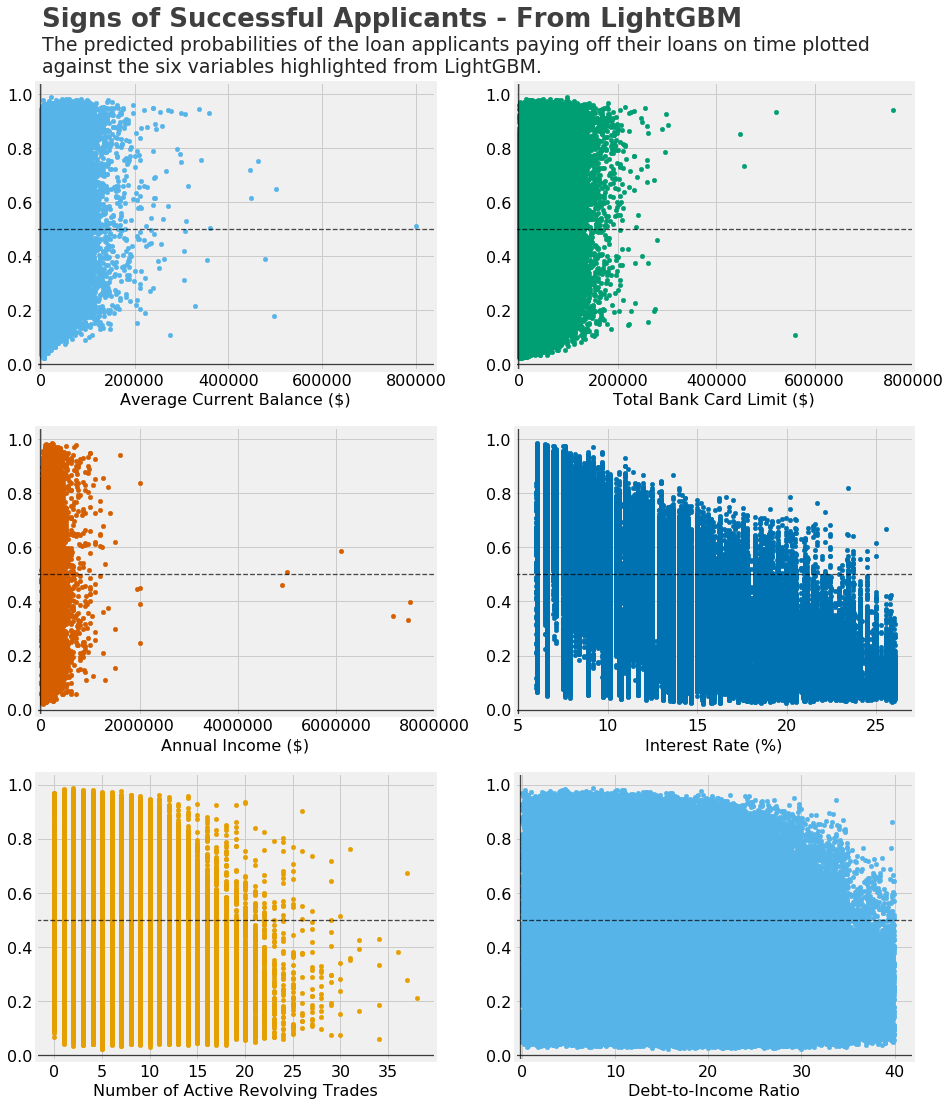

In [94]:
fig = plt.figure(figsize = (14, 18))
# List of axes
axes = []
[axes.append(fig.add_subplot(3,2,(i+1))) for i in range(6)]

axes[0].axhline(.5, 0, 1, linestyle = 'dashed', lw = 1.3, color = 'black', alpha = .7)
predicted_loans_gbm.plot.scatter(x = 'avg_cur_bal', y = 'predicted_loan_status', ax = axes[0], 
                                color = colors[1], fontsize = 16)
axes[0].axvline(-2000, 0, 1, lw = 1.3, color = 'black', alpha = .7)

axes[1].axhline(.5, 0, 1, linestyle = 'dashed', lw = 1.3, color = 'black', alpha = .7)
predicted_loans_gbm.plot.scatter(x = 'total_bc_limit', y = 'predicted_loan_status', ax = axes[1], 
                                color = colors[2], fontsize = 16)
axes[1].axvline(-2000, 0, 1, lw = 1.3, color = 'black', alpha = .7)

axes[2].axhline(.5, 0, 1, linestyle = 'dashed', lw = 1.3, color = 'black', alpha = .7)
predicted_loans_gbm.plot.scatter(x = 'annual_inc', y = 'predicted_loan_status', ax = axes[2], 
                                color = colors[3], fontsize = 16)
axes[2].axvline(-20000, 0, 1, lw = 1.3, color = 'black', alpha = .7)

axes[3].axhline(.5, 0, 1, linestyle = 'dashed', lw = 1.3, color = 'black', alpha = .7)
predicted_loans_gbm.plot.scatter(x = 'int_rate', y = 'predicted_loan_status', ax = axes[3], 
                                color = colors[4], fontsize = 16)
axes[3].axvline(5, 0, 1, lw = 1.3, color = 'black', alpha = .7)

axes[4].axhline(.5, 0, 1, linestyle = 'dashed', lw = 1.3, color = 'black', alpha = .7)
predicted_loans_gbm.plot.scatter(x = 'num_actv_rev_tl', y = 'predicted_loan_status', ax = axes[4],
                                color = colors[0], fontsize = 16)
#axes[4].axvline(0, 0, 1, lw = 1.3, color = 'black', alpha = .7)

axes[5].axhline(.5, 0, 1, linestyle = 'dashed', lw = 1.3, color = 'black', alpha = .7)
predicted_loans_gbm.plot.scatter(x = 'dti', y = 'predicted_loan_status', ax = axes[5],
                                color = colors[1], fontsize = 16)
axes[5].axvline(-.2, 0, 1, lw = 1.3, color = 'black', alpha = .7)

[axis.axhline(0, 0, 1, lw = 1.3, color = 'black', alpha = .7) for axis in axes]

axes[0].set_xlabel('Average Current Balance ($)', fontsize = 16)
axes[1].set_xlabel('Total Bank Card Limit ($)', fontsize = 16)
axes[2].set_xlabel('Annual Income ($)', fontsize = 16)
axes[3].set_xlabel('Interest Rate (%)', fontsize = 16)
axes[4].set_xlabel('Number of Active Revolving Trades', fontsize = 16)
axes[5].set_xlabel('Debt-to-Income Ratio', fontsize = 16)

[axis.set_ylabel('') for axis in axes]
axes[0].set_xticks([0, 200000, 400000, 600000, 800000])
axes[1].set_xticks([0, 200000, 400000, 600000, 800000])
axes[2].set_xticks([0, 2000000, 4000000, 6000000, 8000000])
axes[3].set_xticks([5, 10, 15, 20, 25])
axes[5].set_xticks([0, 10, 20, 30, 40])

axes[0].set_xlim(xmin = -10000)
axes[1].set_xlim(xmin = -10000)
axes[2].set_xlim(xmin = -100000)
axes[3].set_xlim(xmin = 4.8)
#axes[4].set_xlim(xmin = -300)
axes[5].set_xlim(xmin = -.8)

[axis.set_ylim(ymin = -.02) for axis in axes]

axes[0].text(2000, 1.25, "Signs of Successful Applicants - From LightGBM", fontsize = 26, weight = 'bold', alpha = .75)
axes[0].text(2000, 1.08, "The predicted probabilities of the loan applicants paying off their loans on time plotted\nagainst the six variables highlighted from LightGBM.", fontsize = 19, alpha = .85);

We expect to see trends not too different from what we had observed from the random forest model, given LightGBM and random forest are ensembles of decision trees. Indeed:
- We see a clearer downward trend between the predicted probability of paying off loans and the interest rate, meaning the grade given to each application has a major weight in the LightGBM model. 
- We also see the negative trends we have observed for number of active revolving trades and the debt-to-income ratio, which link the applicants' ability to manage their credit and monthly payments to their ability to pay off their loans.
- The trends are not clear for the annual income and total bank card limit, but we should expect the histograms for these variables between the applicants who are predicted to pay off their loans versus those who are predicted to charge off their loans to be similar to the histograms from the random forest model.
- A positive trend between the average current balance and the predicted probability of paying off loans is observed.

Now that we have made predictions on loan applications from 2012 to 2014 with our model of choice, let us further study the characteristics of these loan applicants. We've previously looked at traits like income, interest rates, payment terms, and home ownership. We would like to know more about their employment and purposes for taking out loans.

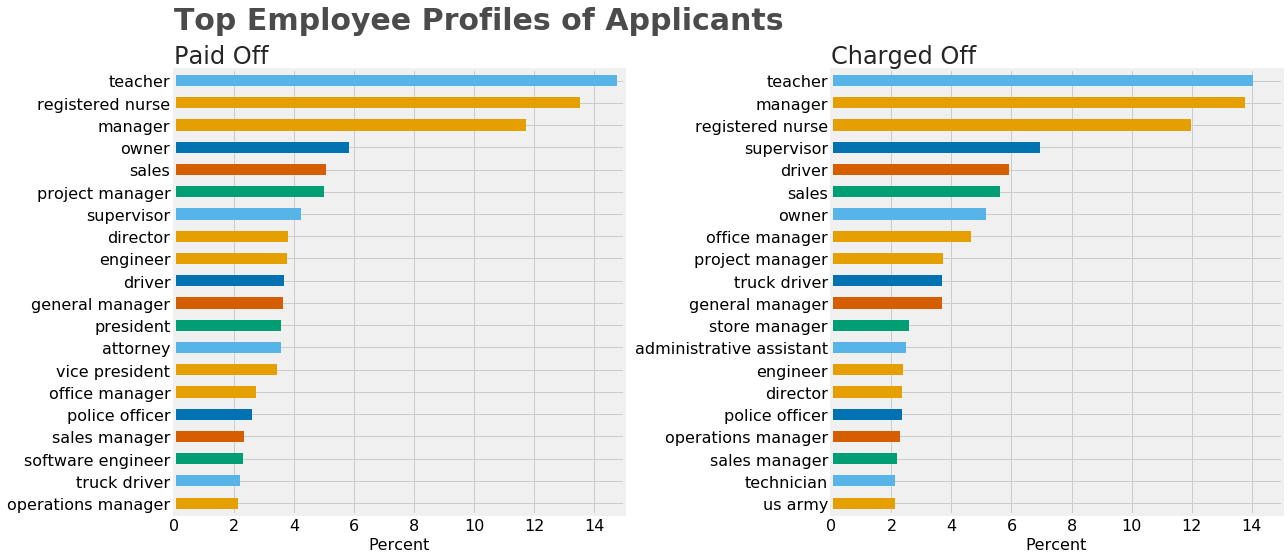

In [95]:
prepared_loans_gbm = prepared_loans.copy()
prepared_loans_gbm['predicted_loan_status'] = predictions_gbm

# Two DataFrames filtered by prediction
payoff_gbm = prepared_loans_gbm[prepared_loans_gbm['predicted_loan_status'] == 1]
chargeoff_gbm = prepared_loans_gbm[prepared_loans_gbm['predicted_loan_status'] == 0]

# Get top 20 occupations from applicants who are expected to pay off their loans, present as percentages
occupation_payoff = payoff_gbm['emp_title'].str.lower()
occupation_payoff = occupation_payoff.str.replace('\\brn\\b', 'registered nurse')
top_occupation_payoff = occupation_payoff.value_counts().sort_values(ascending = False)
top_20_occupation_payoff = top_occupation_payoff[:20] / top_occupation_payoff[:20].sum() * 100

# Get top 20 occupations from applicants who are expected to charge off their loans, present as percentages
occupation_chargeoff = chargeoff_gbm['emp_title'].str.lower()
occupation_chargeoff = occupation_chargeoff.str.replace('\\brn\\b', 'registered nurse')
top_occupation_chargeoff = occupation_chargeoff.value_counts().sort_values(ascending = False)
top_20_occupation_chargeoff = top_occupation_chargeoff[:20] / top_occupation_chargeoff[:20].sum() * 100

fig = plt.figure(figsize = (18, 7))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

top_20_occupation_payoff[::-1].plot.barh(ax = ax1, fontsize = 16, color = colors)
top_20_occupation_chargeoff[::-1].plot.barh(ax = ax2, fontsize = 16, color = colors)

ax1.set_xlabel('Percent', fontsize = 16)
ax2.set_xlabel('Percent', fontsize = 16)

ax1.text(0, 21.3, 'Top Employee Profiles of Applicants', 
         fontsize = 30, weight = 'bold', alpha = .7)
ax1.text(0, 19.8, 'Paid Off', fontsize = 24, alpha = .85)
ax2.text(0, 19.8, 'Charged Off', fontsize = 24, alpha = .85)

ax1.set_xlim(xmax = 15)
ax2.set_xlim(xmax = 15)

fig.tight_layout()

We are looking at the top 20 occupations among the loan applicants who were predicted to pay off their loans and loan applicants who were predicted to charge off their loans. There is some overlap between the groups. Roughly 28% of the loan applicants are teachers, and teaching is the top occupation in both groups. Managers and registered nurses are among the top three occupations behind teachers in both groups, as well.

What is interesting is seeing which occupations are in the top 20 for loan applicants predicted to pay off their loans and loan applicants predicted to charge off their loans. Those who were predicted to pay off their loans successfully include attorneys, company presidents and vice presidents, and software engineers. These are people who receive large incomes and presumably lead financially stable lives.

Those who were predicted to charge off their loans include store managers, administrative assistants, technicians, and those in the US army. There could be something to question about the financial stability of technicians and administrative assistants. Perhaps turnover is great among administrative assistants, resulting in lower job stability. But we may not be able to say the same about technicians who have been working on their craft in their business for years. 

There are questions we could dig deeper into if we want to relate occupation to success in paying off loans, especially if we have improved counts of occupations by aggregating occupations with similar titles but same job function, or occupations with typing errors. We have to acknowledge, however, that more than one variable is important with regards to predicting the success of loan applications.

Finally, let us look at the common purposes for taking out loans among the loan applicants.

Text(0.5,0,'Percent')

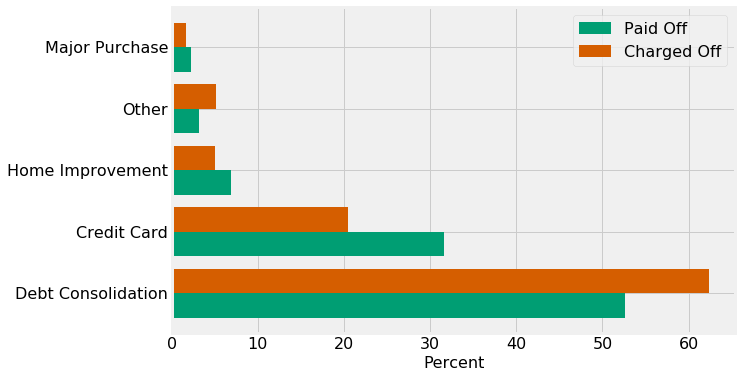

In [96]:
# Get purposes in terms of percentages. Sorted by default.
purpose_payoff = payoff_gbm['purpose'].value_counts() / payoff_gbm.shape[0] * 100
purpose_chargeoff = chargeoff_gbm['purpose'].value_counts() / chargeoff_gbm.shape[0] * 100

# Look at top five purposes
purpose_payoff = purpose_payoff[:5]
purpose_payoff = purpose_payoff.reindex(['debt_consolidation', 'credit_card', 'home_improvement', 
                                         'other', 'major_purchase'])
purpose_chargeoff = purpose_chargeoff[:5]
purpose_chargeoff = purpose_chargeoff.reindex(['debt_consolidation', 'credit_card', 'home_improvement', 
                                               'other', 'major_purchase'])

purpose = pd.concat((purpose_payoff, purpose_chargeoff), axis = 1)
purpose.index = ['Debt Consolidation', 'Credit Card', 'Home Improvement', 
                 'Other', 'Major Purchase']

fig = plt.figure(figsize = (9, 6))
ax = fig.add_subplot(111)
purpose.plot(color = colors[2:], kind = 'barh', fontsize = 16, width = .8, ax = ax)
ax.legend(['Paid Off', 'Charged Off'], fontsize = 16)
ax.set_xlabel('Percent', fontsize = 16)

We see that a majority of the loan applicants wish to take out a loan for debt consolidation. However, within this group of applicants, an investor following our machine learning model will be rejecting more loans than accepting them. The opposite can be said for loan applicants who wish to take out loans for their credit cards, home improvement, and major purchases.

# Using Our Model on Income Applications
We have tried out three machine learning algorithms for predicting the loan applicants' ability to pay off their loans on time, and we were the most satisfied with the LightGBM model, which employs gradient boosted decision trees. By testing the model on our dataset from 2012 to 2014, we would expect our model's sensitivity, or true positive rate, to be almost 27%, and our model's false positive rate to be almost 9%. These results will likely satisfy a conservative investor who wishes to avoid loans that are likely to not be paid off on time.

We would, however, wish to test our machine learning model once more by applying it to incoming loan applications that the model has never seen before. We will train our LightGBM model on the 2012-2014 loan applications and use it to make predictions on the dataset of loan applications from 2015. We will pretend that these reprsent all incoming loan applications in 2015, even though we are reading from a Lending Club dataset that only includes _accepted_ loan applications from 2015.

We will need to prepare the 2015 dataset to make sure it contains the features present in our 2012-2014 dataset. We also need to work with missing values and convert non-numeric features into numeric features.

We will also be removing data points where the loan status is not "Fully Paid" or "Charged Off", as these data points will not help us evaluate our model's performance. In practice, a prediction would be made to every loan application, as the loan status is not known _a priori_.

In [97]:
# Read raw dataset of the 2015 loan applications, skipping the header row
loans_2015 = pd.read_csv('LoanStats3d.csv', skiprows = 1)

# Filter columns so we only have the columns we have kept in the 2012-2014 dataset
# Use the DataFrame made before the categorical columns were converted into dummy columns
# One hot encoding still needs to be performed on the 2015 dataset
loans_2015 = loans_2015[prepared_loans.columns]

# Remove columns we have said were collinear in the 2012-2014 dataset
loans_2015 = loans_2015.drop(columns = ['installment', 'open_acc', 'tot_hi_cred_lim'])

# Remove data points that have loans that do not meet the credit policy
loans_2015 = loans_2015[(loans_2015['loan_status'] == 'Fully Paid') |
                        (loans_2015['loan_status'] == 'Charged Off')]

# Replace the loan_status string values to binary, as specified in the loan_status_mapping dictionary
loans_2015 = loans_2015.replace(loan_status_mapping)

loans_2015.shape

/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (0,19,55) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(333478, 44)

Let us convert the int_rate and revol_util columns into columns with numerical values.

In [98]:
for c in ['int_rate', 'revol_util']:
    loans_2015[c] = loans_2015[c].str.rstrip('%').astype('float')

Let us check for missing values in the columns in the 2015 dataset.

In [99]:
# Check the number of missing/null values in each column. Represent as fractions out of the number of data points
null_counts = loans_2015.isnull().sum()
null_fractions = null_counts / loans_2015.shape[0]

print('Fractions:')
print(null_fractions[null_fractions > 0].sort_values(ascending = False))

Fractions:
mths_since_recent_inq    0.099815
emp_title                0.057407
emp_length               0.057326
mo_sin_old_il_acct       0.029591
bc_util                  0.010405
revol_util               0.000408
dti                      0.000006
num_rev_accts            0.000003
dtype: float64


We will need to do the feature engineering to the emp_length column as we have done before. This time around, we will be performing imputation on the rest of the numerical columns (we are excluding emp_title once again), which we recognize to contain numerical values. 

In [100]:
# Replace emp_length strings with numbers, as specified in the mapping_dict dictionary
loans_2015 = loans_2015.replace(mapping_dict)
# Ensure that remaining missing values are also replaced with 0s
loans_2015['emp_length'] = loans_2015['emp_length'].fillna(0)

# Separate emp_title from the DataFrame
emp_title = loans_2015['emp_title']
loans_2015 = loans_2015.drop(columns = ['emp_title'])

# Check remaining features with more than 1% missing values
null_counts = loans_2015.isnull().sum()
null_fractions = null_counts / loans_2015.shape[0]
null_features = null_fractions[null_fractions > 0].index

# Replace the missing values in each column listed in null_feature with their median
for c in null_features:
    loans_2015[c] = loans_2015[c].fillna(loans_2015[c].median())

# See which columns still contain missing values
null_counts = loans_2015.isnull().sum()
(null_counts / loans_2015.shape[0]).sort_values(ascending = False).head()

total_il_high_credit_limit    0.0
delinq_2yrs                   0.0
acc_now_delinq                0.0
collections_12_mths_ex_med    0.0
initial_list_status           0.0
dtype: float64

Lastly, let's convert the remaining categorical columns into dummy columns.

In [101]:
# Create dummy columns from remaining object columns
dummy_df = pd.get_dummies(loans_2015[['home_ownership', 'verification_status',
                                      'purpose', 'term', 'initial_list_status']])

# Add dummy columns back to original DataFrame while removing original categorical columns
cleaned_loans_2015 = pd.concat([loans_2015, dummy_df], axis = 1)
cleaned_loans_2015 = cleaned_loans_2015.drop(columns =['home_ownership', 'verification_status',
                                                       'purpose', 'term', 'initial_list_status'])

print(cleaned_loans_2015.dtypes.value_counts())
cleaned_loans_2015.head()

float64    37
uint8      25
int64       1
dtype: int64


,loan_amnt,int_rate,emp_length,annual_inc,loan_status,dti,delinq_2yrs,inq_last_6mths,pub_rec,revol_bal,...,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding,term_ 36 months,term_ 60 months,initial_list_status_f,initial_list_status_w
0,28000.0,6.49,10.0,92000.0,1,21.60,0.0,0.0,0.0,51507.0,...,0,0,0,0,0,0,1,0,0,1
2,12000.0,10.78,3.0,40000.0,1,31.95,3.0,0.0,0.0,11008.0,...,0,0,0,0,0,0,1,0,0,1
3,33600.0,10.78,8.0,104000.0,1,14.01,0.0,2.0,0.0,28475.0,...,0,0,0,0,0,0,1,0,0,1
4,11550.0,16.59,5.0,38000.0,0,21.07,0.0,0.0,0.0,7179.0,...,0,0,0,0,0,0,0,1,0,1
5,25000.0,7.49,10.0,109000.0,1,26.02,0.0,1.0,0.0,20862.0,...,0,0,0,0,0,0,1,0,0,1


Let us verify that we have the correct number of columns.

In [102]:
features_2015 = cleaned_loans_2015.drop(columns = ['loan_status'])
target_2015 = cleaned_loans_2015['loan_status']

print(features.dtypes.value_counts())
print(features_2015.dtypes.value_counts())

float64    38
uint8      26
dtype: int64
float64    37
uint8      25
dtype: int64


We notice that two columns from the original features DataFrame are missing from our features_2015 DataFrame.

In [103]:
columns_training = set(features.columns)
columns_2015 = set(features_2015.columns)

# Examine columns present in features, but not in features_2015
print(list(columns_training - columns_2015))
# Examine columns present in features_2015, but not in features
print(list(columns_2015 - columns_training))

['predicted_loan_status', 'home_ownership_NONE', 'home_ownership_OTHER']
['purpose_educational']


In our analysis of the prediction results from before, we appear to have kept the "predicted_loan_status" column. We can remove this.

In our filtered 2015 dataset, none of the loan applicants answered "NONE" or "OTHER" for home ownership. We can add these columns into the 2015 dataset by adding dummy columns with all zeros, indicating none of the applicants said "NONE" or "OTHER".

Meanwhile, none of the loan applicants answered "educational" for purpose in our training set. We will add a dummy column to our training dataset. Our model will, therefore, not be trained on data points where the borrower wishes to take a loan for education, and this may affect our model's performance.

In [105]:
# Remove extraneous "predicted_loan_status" column
features.drop(columns = ['predicted_loan_status'], inplace = True)

# Add zero columns for the remaining home_ownership answers. These will be dummy columns
features_2015['home_ownership_NONE'] = np.zeros(features_2015.shape[0])
features_2015['home_ownership_OTHER'] = np.zeros(features_2015.shape[0])

# Add a dummy column with all zeros to the training DataFrame
features_training = features
features_training['purpose_educational'] = np.zeros(features_training.shape[0])

columns_training = set(features_training.columns)
columns_2015 = set(features_2015.columns)

print(list(columns_training - columns_2015))
print(list(columns_2015 - columns_training))

[]
[]


Our training and test DataFrames now have the same columns. It is now time to apply our LightGBM machine learning model to predict the loan status for our 2015 loan applications. We will be using mostly the same parameters, although we will use cross validation to confirm one of our parameters, "min_data_in_leaf".

In [134]:
parameters = {
    'min_data_in_leaf': [100, 500, 1000]
}

gbm = lgb.LGBMClassifier(objective = 'binary', verbose = 0, max_depth = 10, 
                         learning_rate = 0.02,n_estimators = 1000, 
                         num_leaves = 100, scale_pos_weight = 1/11.)
# min_data_in_leaf = 1000, 
gbm_grid = GridSearchCV(gbm, param_grid = parameters, scoring = 'roc_auc', cv = 3, refit = True, n_jobs = 1)

gbm_grid.fit(features, target)
print('Best parameters from GridSearchCV: ')
print(gbm_grid.best_params_)

gbm = gbm_grid.best_estimator_
    
gbm.fit(features, target,
        eval_set=[(features_2015, target_2015)],
        eval_metric='auc',
        early_stopping_rounds=5)

y_pred_train = gbm.predict(features, num_iteration=gbm.best_iteration_)
y_pred_2015 = gbm.predict(features_2015, num_iteration=gbm.best_iteration_)

print('Training:')
tpr_and_fpr(y_pred_train, target)

print('Evaluation on 2015 dataset:') # Make actual predictions on the new data
tpr_and_fpr(y_pred_2015, target_2015)

Best parameters from GridSearchCV: 
{'min_data_in_leaf': 1000}
[1]	valid_0's auc: 0.650864
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's auc: 0.652936
[3]	valid_0's auc: 0.656596
[4]	valid_0's auc: 0.658191
[5]	valid_0's auc: 0.658611
[6]	valid_0's auc: 0.65888
[7]	valid_0's auc: 0.659574
[8]	valid_0's auc: 0.659858
[9]	valid_0's auc: 0.66021
[10]	valid_0's auc: 0.660772
[11]	valid_0's auc: 0.660857
[12]	valid_0's auc: 0.661284
[13]	valid_0's auc: 0.661175
[14]	valid_0's auc: 0.661516
[15]	valid_0's auc: 0.661655
[16]	valid_0's auc: 0.661642
[17]	valid_0's auc: 0.661973
[18]	valid_0's auc: 0.661714
[19]	valid_0's auc: 0.662136
[20]	valid_0's auc: 0.662021
[21]	valid_0's auc: 0.662374
[22]	valid_0's auc: 0.662719
[23]	valid_0's auc: 0.66292
[24]	valid_0's auc: 0.662956
[25]	valid_0's auc: 0.6632
[26]	valid_0's auc: 0.663181
[27]	valid_0's auc: 0.663408
[28]	valid_0's auc: 0.663717
[29]	valid_0's auc: 0.663932
[30]	valid_0's auc: 0.664156
[31]	valid_0's auc: 

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Training:
False positive rate:  0.09472056359809271
True positive rate:  0.3395403869949932
Evaluation on 2015 dataset:
False positive rate:  0.11216026898290837
True positive rate:  0.3332036108631123


By applying our LightGBM machine learning model on the new 2015 dataset, we have a low false positive rate of 11% and a true positive rate of roughly 33%. This will be satisfactory for a conservative investor. Let us take a look at the confusion matrix for this prediction.

In [135]:
confusion_matrix(target_2015, y_pred_2015)

array([[ 63374,   8006],
       [174766,  87332]])

The conservative investor will be funding 71,380, or 21.4%, of the 333,478 loan applications in the filtered 2015 dataset (these number will be different if we had used the full 2015 dataset, as we would in practice). Of the 71,380 loans, 8,006 of the loans in the 2015 dataset were actually charged off. This is 11% of the loans the investor accepts, indicating that the investor will still be making a profit off of the interest from the accepted loans.

Going forward, the LightGBM algorithm can be further trained with the 2015 dataset, especially as these loan applicants begin paying off or defaulting on their loans. This gain in information will be useful if the model is used to predict future loan applications beyond what we have covered here.

# Conclusion
We have developed and applied machine learning models, from logistic regression to LightGBM, to evaluate loans made through the Lending Club from 2012 to 2014. Using this model, a conservative investor will likely fund 20% of loan applications through the Lending Club. Characteristics of the accepted applications include low interest rates, good credit, few active revolving trades, small debt-to-income ratios, and high average balances. 